# Characterization of Parkinson's Disease through clustering of Medical notes

## Introduction

### Importing packages

In [1]:
import numpy as np
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

## Data Pre-processing

### Exploring the data

In [2]:
path = "data/HEHE.csv" 
available_memory = 423464092  # Memory in bytes
memory_per_row = 100  # Example memory usage per row in bytes
target_memory_usage = 0.75 * available_memory
chunk_size = int(target_memory_usage / memory_per_row)
chunk_size

3175980

In [3]:
# Actual way to read large CSV files
chunk = pd.read_csv(path, chunksize=chunk_size, dtype={'dose_unit_source_value': str}) #Raises a DtypeWarning: Columns (11) have mixed types when it is not specified
df = pd.concat(chunk)

In [4]:
df.sample(5)

,person_id,drug_source_value,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
2154119,194868,"{""med_display_name"": ""D5W-0.45 % NaCl infusion...",3161.250000,CONTINUOUS,INTRAVENOUS,50.000,ml/hr,"[**NAME**], MD [**DATE**] 2:07 PM Departm..."
998757,249161,"{""med_display_name"": ""heparin 25,000 units in ...",2.339294,CONTINUOUS,INTRAVENOUS,17.997,Units/kg/hr,"[**NAME**], MD [**DATE**] 12:23 PM DEPARTM..."
1650212,220073,"{""med_display_name"": ""cefTRIAXone (ROCEPHIN) 2...",100.000000,EVERY 12 HOURS,INTRAVENOUS,2.000,g,"""[**NAME**], DO [**DATE**] 5:39 PM Depart..."
1323158,228740,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.500000,5 TIMES DAILY,ORAL,1.500,tablet,"""[**NAME**], RD [**DATE**] 11:46 PM Nutrit..."
1035124,249161,"{""med_display_name"": ""propofol (DIPRIVAN) 10 M...",53.705293,CONTINUOUS,INTRAVENOUS,10.000,mcg/kg/min,"[**NAME**], RD [**DATE**] 4:12 PM Inpatie..."


Actual len of the whole dataset. It has more than 2 Million rows

In [5]:
len(df)

2326300

#### Number of patients in this cohort

In [6]:
df['person_id'].unique().shape

(441,)

#### Dealing with the drug_source_value column

Because the drug_source_value column contains elements as json, we convert them into a dict so that we can use their original keys

In [7]:
drug_source_value = df['drug_source_value'].apply(lambda x: json.loads(x))

In [8]:
len(drug_source_value)

2326300

The keys of the dictionary are those used in the drug_source_value column

In [9]:
drug_source_value[0].keys()

dict_keys(['med_display_name', 'rxnorm_concat', 'med_dose_unit_desc', 'mar_action', 'med_order_desc'])

In [10]:
drug_source_value[865]

{'med_display_name': '0.9 % NaCl infusion',
 'rxnorm_concat': '| 313002 |',
 'med_dose_unit_desc': 'ml/hr',
 'mar_action': 'RATE VERIFY',
 'med_order_desc': 'SODIUM CHLORIDE 0.9 % IV SOLN'}

Current medication used for the treatment of Parkinson's disease

In [11]:
pd_medication = ["carbidopa", "levodopa", "entacapone", "tolcapone", "opicapone", "pramipexole", "ropinirole", "apomorphine", "rotigotine", "selegiline", "rasagiline", "safinamide", "amantadine", "istradefylline", "trihexyphenidyl", "benztropine", "bromocriptine", "cabergoline", "pergolide", "lisuride"]
pd_drug_info = {}

We look for instances of the Parkinson's drugs contained in the pd_medication array in drug_source_value so that we can focus on the medical stories relating to Parkinson's. Takes about 2½ minutes

In [12]:
for i, drug in enumerate(drug_source_value):
    for item in pd_medication:
        if item in drug_source_value[i]['med_display_name']:
            pd_drug_info[i] = drug_source_value[i]['med_display_name'] # I could have also passed the whole dictionary

Only 16K+ rows have information regarding medication for Parkinson's

In [13]:
len(pd_drug_info)

16040

The keys of this new array are the indices or rows in the original DataFrame. These rows contain information regarding Parkinson's medication 

In [14]:
pd_drug_info.keys()

dict_keys([126, 127, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 2353, 2354, 2355, 2438, 2439, 2521, 2522, 2523, 2524, 2525, 2706, 2707, 2708, 2709, 2710, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 3496, 3497, 3498, 3499, 3500, 3501, 350

pd_drug_info is a subset of drug_source_value that contains the name of drugs related to PD

In [15]:
pd_drug_info[1299166]

'cabergoline (DOSTINEX) tablet 1 mg'

In [16]:
drug_source_value[1299166]

{'med_display_name': 'cabergoline (DOSTINEX) tablet 1 mg',
 'rxnorm_concat': '| 199703 |',
 'med_dose_unit_desc': 'mg',
 'mar_action': 'GIVEN',
 'med_order_desc': 'CABERGOLINE 0.5 MG PO TABS'}

Here's our new database. df_pd is a subset of the original dataset that only contains patients that are taking medication for Parkinson's

In [17]:
df_pd = df.iloc[list(pd_drug_info.keys())]
df_pd.sample(10)

,person_id,drug_source_value,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
1359666,222938,"{""med_display_name"": ""carbidopa-levodopa (SINE...",0.0,2 TIMES DAILY,ORAL,0.00,tablet,"[**NAME**], MD [**DATE**] 9:20 PM DEPARTM..."
664126,256706,"{""med_display_name"": ""benztropine (COGENTIN) t...",1.0,2 TIMES DAILY,ORAL,0.50,mg,"[**NAME**], RD [**DATE**] 12:01 PM Medica..."
858720,252733,"{""med_display_name"": ""pramipexole (MIRAPEX) ta...",2.0,3 TIMES DAILY,ORAL,0.25,mg,"""[**NAME**], MD [**DATE**] 4:31 PM Depart..."
2149868,194868,"{""med_display_name"": ""amantadine (SYMMETREL) c...",0.0,2 TIMES DAILY,ORAL,0.00,mg,"""[**NAME**], NP [**DATE**] 5:04 PM [**LOC..."
1439620,220757,"{""med_display_name"": ""carbidopa-levodopa (SINE...",0.5,3 TIMES DAILY,ORAL,0.50,tablet,"[**NAME**], MD [**DATE**] 5:51 PM Please ..."
6770,260680,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,EVERY 2 HOURS PRN,ORAL,2.00,tablet,"[**NAME**], MD [**DATE**] 12:26 PM Departm..."
754908,256348,"{""med_display_name"": ""pramipexole (MIRAPEX) ta...",2.0,3 TIMES DAILY,ORAL,1.00,mg,"""[**NAME**] [**DATE**] 2:09:39 PM Nutr..."
2030931,203512,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,3 TIMES DAILY,ORAL,1.00,tablet,"""[**NAME**], MD [**DATE**] 11:18 AM Depart..."
1391165,221378,"{""med_display_name"": ""amantadine (SYMMETREL) c...",1.0,2 TIMES DAILY,ORAL,100.00,mg,"""[**NAME**], MD [**DATE**] 4:30 PM Vascul..."
1273692,237904,"{""med_display_name"": ""carbidopa-levodopa (SINE...",0.0,3 TIMES DAILY,ORAL,0.00,tablet,"[**NAME**], MD [**DATE**] 6:59 PM The con..."


Creating a new column

In [18]:
df_pd.insert(loc=2, column="drug_info", value=pd_drug_info)
df_pd

,person_id,drug_source_value,drug_info,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
126,261006,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,2.0,EVERY 4 HOURS,ORAL,2.0,tablet,"""[**NAME**], MD [**DATE**] 7:04 PM Depart..."
127,261006,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,2.0,EVERY 4 HOURS,ORAL,2.0,tablet,"""[**NAME**] [**DATE**] 9:51:05 AM Requ..."
955,260996,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,1.0,2 TIMES DAILY,ORAL,100.0,mg,"[**NAME**], ORTHOTIST-PR [**DATE**] 6:02 ..."
956,260996,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,1.0,EVERY OTHER DAY,ORAL,100.0,mg,"""[**NAME**], RD [**DATE**] 11:30 AM Nutrit..."
957,260996,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,1.0,2 TIMES DAILY,ORAL,100.0,mg,[**NAME**] [**DATE**] 7:56 PM Psychology ...
...,...,...,...,...,...,...,...,...,...
2324745,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,0.0,3 TIMES DAILY,ORAL,0.0,tablet,"""[**NAME**], MD [**DATE**] 1:12 PM Geriat..."
2324746,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,0.0,3 TIMES DAILY,ORAL,0.0,tablet,"""[**NAME**] [**DATE**] 11:30 PM Rehab Psyc..."
2324747,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,0.0,3 TIMES DAILY,ORAL,0.0,tablet,"""[**NAME**], RD [**DATE**] 12:48 AM Nutrit..."
2324748,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,0.0,3 TIMES DAILY,ORAL,0.0,tablet,"""[**NAME**], DO [**DATE**] 10:14 AM Neurol..."


In [19]:
df_pd.iloc[955]

person_id                                                            257075
drug_source_value         {"med_display_name": "carbidopa-levodopa (SINE...
drug_info                 carbidopa-levodopa (SINEMET) 12.5-125 MG per t...
quantity                                                                0.5
sig                                                           4 TIMES DAILY
route_source_value                                                     ORAL
dose_source_value                                                       0.5
dose_unit_source_value                                               tablet
note_text                 "[**NAME**], MD     [**DATE**]  9:56 PM [**LOC...
Name: 92436, dtype: object

In [20]:
df_pd.iloc[955]['drug_info']

'carbidopa-levodopa (SINEMET) 12.5-125 MG per tablet 0.5 tablet'

In [21]:
df_pd.iloc[955]['drug_source_value']

'{"med_display_name": "carbidopa-levodopa (SINEMET) 12.5-125 MG per tablet 0.5 tablet", "rxnorm_concat": "| 197445 |", "med_dose_unit_desc": "tablet", "mar_action": "MAR HOLD", "med_order_desc": "CARBIDOPA-LEVODOPA 25-250 MG PO TABS"}'

Let's take a look at the drugs actually used in the dataset. **Note**: vscode truncakes the ouput so it could be that you won't see all the drugs. i.e: Cabergoline (1299166).

In [22]:
# pd_drugs_used is just the list version of lowercase values in pd_drug_info
pd_drugs_used = [item.lower() for item in pd_drug_info.values()]
# Takes the unique values and sorts them to finally be saved in an array
pd_drugs_used_unique = sorted(set(pd_drugs_used))

**Note:** 1299166 is **NOT** the position in the array but rather the key that contains the element. The len for both structures in 16040  

In [23]:
pd_drug_info[1299166]

'cabergoline (DOSTINEX) tablet 1 mg'

In [24]:
len(pd_drug_info) == len(pd_drugs_used)

True

The position in the list that contains item with the key 1299166

In [25]:
list(pd_drug_info.keys()).index(1299166)

7778

In [26]:
pd_drugs_used[7778]

'cabergoline (dostinex) tablet 1 mg'

In [27]:
pd_drugs_used_unique

['* rasagiline mesylate (azilect) 1 mg - pharmacist to verify when brought in',
 '* rasagiline mesylate (azilect) tablet 1 mg - patient to bring and pharmacist to verify',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '*amantadine er (gocovri) extended release capsule 137 mg - patient supplied',
 '*carbidopa-levodopa er (rytary) 36.25-145 mg cpcr 1 tablet - patient supplied',
 '*carbidopa-levodopa er (rytary) 48.75-195 mg cpcr 1 capsule - patient supplied',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 200 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 200 mg',
 'amantadine (symmetrel) solution 50 mg',
 'amantadine (symmetrel) syrup 100 mg',
 'amantadine (symmetrel) syrup 50 mg',
 'amantadine er (gocovri) extended release capsule 137 mg',
 'apomorphine (apokyn) injection 1 ml',
 'benztropine (cogentin) tablet 0.5 mg',
 'benztropine (cogentin) tablet 1 mg',
 'benztropine (cogentin) tablet 2 mg

In [28]:
df_pd.loc[1585078]['drug_info']

'pramipexole (MIRAPEX) tablet 0.25 mg'

Using a ***Regex*** to segment from the pd_drugs_used array the drug_name, generic_name and dosage

In [29]:
# Regex: ? 0 o 1 for the last element. + 1 or more. 
# Matches generic name (Word characters followed by either a space or hyphens) and brand name (A name)
drug_names_pattern = r"([\w\s-]+)\s(?:\(([\w\s-]+)\)\s*)?" 
dosage_pattern = r"\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)*(?:\s*(?:mg/ml|mg|ml))(?:/hr)?"

# Initialize empty lists
generic_names = []
brand_names = []
dosages = []

# Extract information and populate the lists
for string in pd_drugs_used:
    drug_name_match = re.findall(drug_names_pattern, string)
    if drug_name_match:
        generic_name, brand_name = drug_name_match[0]
        generic_names.append(generic_name)

        if brand_name:
            brand_names.append(brand_name)
        else:
            brand_names.append(np.nan)

        dosage_match = re.findall(dosage_pattern, string)
        
        if dosage_match:
            dosages.append(dosage_match[0])
        else:
            dosages.append(np.nan)
    else:
        # Nice way to remove outlier and keeping the length the same
        print(string)
        generic_names.append(np.nan)


# Create DataFrame
pd_data = pd.DataFrame({
    "generic_name": generic_names,
    "brand_name": brand_names,
    "dosage": dosages
})

In [30]:
pd_data.sample(20)

,generic_name,brand_name,dosage
14763,carbidopa-levodopa,sinemet,10-100 mg
11143,carbidopa-levodopa,sinemet cr,50-200 mg
7170,pramipexole,mirapex,0.125 mg
13405,carbidopa-levodopa,sinemet,25-100 mg
7227,carbidopa-levodopa,sinemet cr,25-100 mg
5043,rasagiline mesylate,azilect,1 mg
14872,amantadine,symmetrel,100 mg
4306,carbidopa-levodopa,sinemet,25-100 mg
15119,carbidopa-levodopa,sinemet,25-100 mg
15303,carbidopa-levodopa,parcopa,10-100 mg


In [31]:
print(pd_data['generic_name'].to_string())

0                                carbidopa-levodopa
1                                carbidopa-levodopa
2                                        amantadine
3                                        amantadine
4                                        amantadine
5                                        amantadine
6                                        amantadine
7                                        amantadine
8                                        amantadine
9                                        amantadine
10                                       amantadine
11                                       amantadine
12                                       amantadine
13                                       amantadine
14                                       amantadine
15                                       amantadine
16                                       amantadine
17                                       amantadine
18                                       amantadine
19          

In [32]:
# There's an inconsistency with this. The RxCUI code associated with it (885205) actually shows 1 mg not 0.5. See: https://mor.nlm.nih.gov/RxNav/search?searchBy=RXCUI&searchTerm=885205
df_pd['drug_source_value'].iloc[3013]

'{"med_display_name": "benztropine mesylate (COGENTIN) injection 0.5 mg", "rxnorm_concat": "| 885205 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "BENZTROPINE MESYLATE 1 MG/ML IJ SOLN"}'

In [33]:
pd_data.iloc[3013]

generic_name    benztropine mesylate
brand_name                  cogentin
dosage                        0.5 mg
Name: 3013, dtype: object

In [34]:
# Notice that for selegiline the generic_name still contains the dosage and form of administration. This is because, for selegiline, the name string doesn't contain the brand name   
pd_data.iloc[13628]

generic_name    selegiline tablet 5 mg
brand_name                         NaN
dosage                            5 mg
Name: 13628, dtype: object

#### Dealing with missing data

In [35]:
# Taking a look at the rows where there are missing values 
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                     generic_name brand_name         dosage
3333               carbidopa-levodopa patient own        NaN            NaN
3334               carbidopa-levodopa patient own        NaN            NaN
3335               carbidopa-levodopa patient own        NaN            NaN
5187                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5188                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5189                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5190                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5191                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5192                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5193                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5194                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5195                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5196        

Using the pd_drugs_used_unique list to fill in the blanks

In [36]:
pd_drugs_used[5187:5199]

['**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med']

In [37]:
pd_drugs_used[7346:7390]

['inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodo

In [38]:
# Regex couldn't catch the brand name because it was in a different position, so we add it manually
pd_data.loc[pd_data.index[5187:5199], 'brand_name'] = 'duopa'
# Patient is taking LCIG, most likely it is duopa (this is an assumption)
pd_data.loc[pd_data.index[7346:7390], 'brand_name'] = 'duopa'

In [39]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                     generic_name brand_name dosage
3333               carbidopa-levodopa patient own        NaN    NaN
3334               carbidopa-levodopa patient own        NaN    NaN
3335               carbidopa-levodopa patient own        NaN    NaN
7368   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7369   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7370   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7371   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7372   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7373   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7374   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7375   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7376   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7377   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7378   inv levodopa-carbidopa intestinal gel pum

Looking for evidence of other brand names for Selegiline in our database

In [40]:
selegiline = pd_data[(pd_data['brand_name'] == 'eldepryl')| (pd_data['brand_name'] == 'zelapar')]
selegiline['brand_name'].unique()

array(['eldepryl'], dtype=object)

In [41]:
print(selegiline.to_string())

      generic_name brand_name dosage
432     selegiline   eldepryl   5 mg
433     selegiline   eldepryl   5 mg
434     selegiline   eldepryl   5 mg
435     selegiline   eldepryl   5 mg
436     selegiline   eldepryl   5 mg
437     selegiline   eldepryl   5 mg
438     selegiline   eldepryl   5 mg
439     selegiline   eldepryl   5 mg
440     selegiline   eldepryl   5 mg
441     selegiline   eldepryl   5 mg
442     selegiline   eldepryl   5 mg
443     selegiline   eldepryl   5 mg
444     selegiline   eldepryl   5 mg
445     selegiline   eldepryl   5 mg
446     selegiline   eldepryl   5 mg
447     selegiline   eldepryl   5 mg
6110    selegiline   eldepryl   5 mg
7594    selegiline   eldepryl   5 mg
7595    selegiline   eldepryl   5 mg
7596    selegiline   eldepryl   5 mg
13507   selegiline   eldepryl   5 mg
13508   selegiline   eldepryl   5 mg
13509   selegiline   eldepryl   5 mg
13510   selegiline   eldepryl   5 mg
13511   selegiline   eldepryl   5 mg
13512   selegiline   eldepryl   5 mg
1

In [42]:
# Making sure the word "tablet" isn't present in the drug's generic name
for index, name in enumerate(generic_names):
    if 'tablet' in name:
        print(name, index)

selegiline tablet 5 mg 13628
selegiline tablet 5 mg 13629
selegiline tablet 5 mg 13630
selegiline tablet 5 mg 13631
selegiline tablet 5 mg 13632
selegiline tablet 5 mg 13633
selegiline tablet 5 mg 13634
selegiline tablet 5 mg 13635
selegiline tablet 5 mg 13636
selegiline tablet 5 mg 13637
selegiline tablet 5 mg 13638
selegiline tablet 5 mg 13639


Blindfully assuming that the medication taken by the patient was in fact eldepryl

In [43]:
pd_data.loc[pd_data.index[13628:13640], 'brand_name'] = 'eldepryl'
# Replacing "selegiline tablet 5mg for just selegiline"
pd_data.loc[pd_data.index[13628:13640], 'generic_name'] = 'selegiline'

In [44]:
pd_data.loc[pd_data.index[13628:13640]]

,generic_name,brand_name,dosage
13628,selegiline,eldepryl,5 mg
13629,selegiline,eldepryl,5 mg
13630,selegiline,eldepryl,5 mg
13631,selegiline,eldepryl,5 mg
13632,selegiline,eldepryl,5 mg
13633,selegiline,eldepryl,5 mg
13634,selegiline,eldepryl,5 mg
13635,selegiline,eldepryl,5 mg
13636,selegiline,eldepryl,5 mg
13637,selegiline,eldepryl,5 mg


For "carbidopa-levodopa patient own med" we aren't sure about the medication (sinemet, sinemet cr, etc) or dosage, so I will leave it as is. Same for the dosage of "duopa"

In [45]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                    generic_name brand_name dosage
3333              carbidopa-levodopa patient own        NaN    NaN
3334              carbidopa-levodopa patient own        NaN    NaN
3335              carbidopa-levodopa patient own        NaN    NaN
7368  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7369  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7370  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7371  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7372  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7373  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7374  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7375  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7376  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7377  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7378  inv levodopa-carbidopa intestinal gel pump      duopa   

In [46]:
pd_data.loc[pd_data.index[13628:13640]]

,generic_name,brand_name,dosage
13628,selegiline,eldepryl,5 mg
13629,selegiline,eldepryl,5 mg
13630,selegiline,eldepryl,5 mg
13631,selegiline,eldepryl,5 mg
13632,selegiline,eldepryl,5 mg
13633,selegiline,eldepryl,5 mg
13634,selegiline,eldepryl,5 mg
13635,selegiline,eldepryl,5 mg
13636,selegiline,eldepryl,5 mg
13637,selegiline,eldepryl,5 mg


In [47]:
pd_data[pd_data['generic_name'] == 'selegiline']

,generic_name,brand_name,dosage
432,selegiline,eldepryl,5 mg
433,selegiline,eldepryl,5 mg
434,selegiline,eldepryl,5 mg
435,selegiline,eldepryl,5 mg
436,selegiline,eldepryl,5 mg
...,...,...,...
13635,selegiline,eldepryl,5 mg
13636,selegiline,eldepryl,5 mg
13637,selegiline,eldepryl,5 mg
13638,selegiline,eldepryl,5 mg


In [48]:
df_pd.insert(loc=3, column="generic_name", value=pd_data['generic_name'].to_list())
df_pd.insert(loc=4, column="brand_name", value=pd_data['brand_name'].to_list())
df_pd.insert(loc=5, column="dosage", value=pd_data['dosage'].to_list())

In [49]:
df_pd.sample(20)

,person_id,drug_source_value,drug_info,generic_name,brand_name,dosage,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
664259,256706,"{""med_display_name"": ""benztropine (COGENTIN) t...",benztropine (COGENTIN) tablet 0.5 mg,benztropine,cogentin,0.5 mg,0.0,2 TIMES DAILY,ORAL,0.0,mg,"""[**NAME**], MD [**DATE**] 10:05 PM Palli..."
2239945,187199,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,0.5,EVERY 24 HOURS,ORAL,0.5,tablet,"""[**NAME**], PhD [**DATE**] 10:36 AM REHAB..."
1439614,220757,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,0.5,2 TIMES DAILY,ORAL,0.5,tablet,"[**NAME**], MD [**DATE**] 10:58 AM See pri..."
2231043,187800,"{""med_display_name"": ""rasagiline mesylate (AZI...",rasagiline mesylate (AZILECT) tablet 1 mg,rasagiline mesylate,azilect,1 mg,1.0,DAILY,ORAL,1.0,mg,"[**NAME**], MD [**DATE**] 4:54 AM Vascula..."
2240017,187199,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,3.0,4 TIMES DAILY,ORAL,3.0,tablet,"""[**NAME**], PhD [**DATE**] 10:36 AM REHAB..."
1421100,220757,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 200 mg,amantadine,symmetrel,200 mg,2.0,NIGHTLY,ORAL,200.0,mg,"""[**NAME**], RN [**DATE**] 6:20 PM Vascul..."
2091437,201023,"{""med_display_name"": ""carbidopa-levodopa-entac...",carbidopa-levodopa-entacapone (STALEVO) 50-200...,carbidopa-levodopa-entacapone,stalevo,50-200-200 mg,1.0,2 TIMES DAILY,ORAL,1.0,tablet,"""[**NAME**] [**DATE**] 4:48 PM [**LOCATIO..."
897107,252548,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,1.0,ONCE,ORAL,1.0,Tablet,"[**NAME**], MD [**DATE**] 6:54 AM Full Dr..."
2240019,187199,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,2.5,2 TIMES DAILY,ORAL,2.5,tablet,[**NAME**] [**DATE**] 11:20 PM Rehab Psych...
2036606,203021,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,2.0,ONCE,ORAL,2.0,tablet,"""[**NAME**], RD [**DATE**] 9:01 PM Nutrit..."


### Creating the corpus from medical notes 

#### Using the note_text column for raw data

In [50]:
corpus_raw = list(df_pd["note_text"])

#### Removing words that don't contain much meaning from our notes

In [51]:
words_to_remove = ["Department of Neurosurgery Date of Consult", "Department of Orthopedics Consultation Note Date of Consult", "Geriatric Medicine Consult Date of Consult", "INPATIENT MEDICAL NUTRITION THERAPY", "MSW", "RN" ,"evidence", "Read By", "images", "report", "concur", "findings", "agree", "seen", "residents", "resident", "Resident", "unspecified provider", "Released Date Time", "personally reviewed" ,"D.O", "MD", "M.D.", "Electronically Verified By", "NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]
# words_to_remove = ["NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]

# words_to_remove = words_to_remove + list(STOPWORDS)
corpus_clean = []
for item in corpus_raw:
    for word in words_to_remove:
        item = item.replace(word, '') 
    corpus_clean.append(item)

In [52]:
df_pd['note_text'].iloc[989]

'"[**NAME**], PA-C     [**DATE**]  2:16 PM [**LOCATION_INSTITUTE**] [**LOCATION_CITY**] Division of Infectious Disease Consult History & Physical Admit Date: [**DATE**]  LOS: 2 days Date of Consult: [**DATE**] Requesting Physician: Dr [**NAME**] Subjective: [**NAME**] is a 60 y.o. female admitted for Infection and inflammatory reaction due to device, implant, and graft, initial encounter ID has been consulted for infected right chest IPG. Fever monitoring: Temp (24hrs), Avg:37.1 degC (98.8 degF), Min:36.8 degC (98.2 degF), Max:37.4 degC (99.4 degF) Location: Right chest Quality:  Device erosion through the skin, pain, redness, drainage Severity:  Moderate/severe Duration:  Infection since [**DATE**] Timing: Not resolving Context: Ms. [**NAME**] is a 60 y/o female with a hx of Parkinson\'s disease with a deep brain stimulator in place since [**DATE**]. Is admitted for exposed and infected right chest implanted pulse generator. It was placed [**DATE**] and complicated by infection of the

#### Taking each word from the cleaned corpus and making it lowercase

In [53]:
corpus = [word.lower() for word in corpus_clean]
corpus[989]

'", pa-c       2:16 pm   division of infectious disease consult history & physical admit date:   los: 2 days date of consult:  requesting physician: dr  subjective:  is a 60 y.o. female admitted for infection and inflammatory reaction due to device, implant, and graft, initial encounter id has been consulted for infected right chest ipg. fever monitoring: temp (24hrs), avg:37.1 degc (98.8 degf), min:36.8 degc (98.2 degf), max:37.4 degc (99.4 degf) location: right chest quality:  device erosion through the skin, pain, redness, drainage severity:  moderate/severe duration:  infection since  timing: not resolving context: ms.  is a 60 y/o female with a hx of parkinson\'s disease with a deep brain stimulator in place since . is admitted for exposed and infected right chest implanted pulse generator. it was placed  and complicated by infection of the device . she was treated with a 6 week course of iv vancomycin, cefepime, and po rifampin which she finished 1 week ago. despite completing th

#### Adding the pre-processed version of the notes to the DataFrame

In [54]:
df_pd["note_text"] = corpus
df_pd

/tmp/ipykernel_69512/3981818334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd["note_text"] = corpus


,person_id,drug_source_value,drug_info,generic_name,brand_name,dosage,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
126,261006,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,2.0,EVERY 4 HOURS,ORAL,2.0,tablet,""", 7:04 pm department of medicine divis..."
127,261006,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,2.0,EVERY 4 HOURS,ORAL,2.0,tablet,""" 9:51:05 am requesting service: fami..."
955,260996,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,amantadine,symmetrel,100 mg,1.0,2 TIMES DAILY,ORAL,100.0,mg,", orthotist-pr 6:02 pm pt. seen for fit/..."
956,260996,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,amantadine,symmetrel,100 mg,1.0,EVERY OTHER DAY,ORAL,100.0,mg,""", rd 11:30 am nutrition consult date of ..."
957,260996,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,amantadine,symmetrel,100 mg,1.0,2 TIMES DAILY,ORAL,100.0,mg,7:56 pm psychology initial evaluation ...
...,...,...,...,...,...,...,...,...,...,...,...,...
2324745,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""", 1:12 pm : current patient location:..."
2324746,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""" 11:30 pm rehab psychology consultation ..."
2324747,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""", rd 12:48 am nutrition consult reason f..."
2324748,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""", do 10:14 am neurology consultation sub..."


In [55]:
len(corpus)

16040

In [56]:
corpus[1]

'"          9:51:05 am requesting service: family medicine, dr.  patient active problem list diagnoses code * long-term current use of opiate analgesic v58.69ac * ddd (degenerative disc disease), lumbar 722.52g * ddd (degenerative disc disease), cervical 722.4g * oa (osteoarthritis of spine) 721.90l * reaction to chronic stress 309.9cv * generalized anxiety disorder 300.02 * ed (erectile dysfunction) of organic origin 607.84s * encounter for long-term (current) use of high-risk medication v58.69u * djd (degenerative joint disease)  cervical and lumbar 715.90aj * hx/o  outbursts of anger had therapy and ok 312.00m * chronic intractable pain 338.29d * insomnia  multifactorial 780.52a * dyslipidemia - high ldl. 272.0 * hsv, gluteal region 054.9bh * lichenoid dermatitis plantis, diffuse 692.9ee * nutcracker esophagus with spasm 530.5aa * vocal cord dysfunction. 478.5ac * history of peptic ulcer disease v12.71 * hiatal hernia. 553.3b * gerd (gastroesophageal reflux disease). 530.81s * chole

In [57]:
df_pd['person_id'].unique()

array([261006, 260996, 260956, 260918, 260872, 260789, 260769, 260735,
       260680, 260382, 260268, 260102, 259994, 259937, 259505, 259469,
       259217, 258899, 258855, 258837, 258153, 258130, 258122, 258078,
       258076, 258074, 258045, 258015, 257685, 257569, 257440, 257257,
       257236, 257128, 257120, 257075, 256936, 256708, 256706, 256680,
       256628, 256348, 255675, 255671, 255398, 255327, 255046, 254942,
       254666, 254367, 254301, 253781, 253712, 253679, 253665, 253615,
       253410, 253326, 253316, 252834, 252733, 252727, 252725, 252548,
       252405, 252141, 252024, 251367, 251082, 250811, 250804, 250766,
       250583, 250228, 250105, 250078, 249890, 249713, 249691, 249643,
       249614, 249161, 249084, 248934, 248844, 248836, 248403, 247869,
       247690, 247394, 246662, 246383, 245632, 245615, 245457, 245208,
       244116, 244070, 243926, 243410, 242516, 241867, 241743, 241733,
       241559, 241426, 240979, 240927, 240655, 240288, 239108, 238908,
      

In [58]:
len(df_pd['person_id'].unique())

286

Looking for ocurrences of the word "updrs" in the database

In [59]:
indexes = []
for i, item in enumerate(corpus):
    if 'updrs' in item:
        indexes.append(i)

In [60]:
indexes

[10441, 10451, 10460, 10474, 10484, 10497, 12625, 14305, 14327, 14349]

Filtering out those rows

In [61]:
df_pd.iloc[indexes]

,person_id,drug_source_value,drug_info,generic_name,brand_name,dosage,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
1646081,220195,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.0,tablet,", 12:01 pm neurology consultation subspe..."
1646091,220195,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,2.0,3 TIMES DAILY,ORAL,2.0,tablet,", 12:01 pm neurology consultation subspe..."
1646100,220195,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,2.5,4 TIMES DAILY,ORAL,2.5,tablet,", 12:01 pm neurology consultation subspe..."
1646354,220195,"{""med_display_name"": ""entacapone (COMTAN) tabl...",entacapone (COMTAN) tablet 200 mg,entacapone,comtan,200 mg,1.0,4 TIMES DAILY,ORAL,200.0,mg,", 12:01 pm neurology consultation subspe..."
1646364,220195,"{""med_display_name"": ""entacapone (COMTAN) tabl...",entacapone (COMTAN) tablet 200 mg,entacapone,comtan,200 mg,1.0,4 TIMES DAILY,ORAL,200.0,mg,", 12:01 pm neurology consultation subspe..."
1646377,220195,"{""med_display_name"": ""entacapone (COMTAN) tabl...",entacapone (COMTAN) tablet 200 mg,entacapone,comtan,200 mg,0.0,4 TIMES DAILY,ORAL,0.0,mg,", 12:01 pm neurology consultation subspe..."
1979665,206133,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.0,tablet,""", 1:21 am neurology consultation subsp..."
2108392,199862,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.0,tablet,""", 5:08 pm neurology consultation subsp..."
2108414,199862,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.0,tablet,""", 5:08 pm neurology consultation subsp..."
2108436,199862,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""", 5:08 pm neurology consultation subsp..."


Only in 3 patients there's mention of the updrs 

In [62]:
df_pd.iloc[indexes]['person_id'].unique()

array([220195, 206133, 199862])

In [63]:
print(df_pd.iloc[10441]['note_text'])

,       12:01 pm neurology consultation subspecialty service: general consult requested of: neurology consult requested by:  (dr. ) reason for consult: worsening parkinsonism and increasing falls assessment/plan: this is a 78 y.o. male here for increased gait instability with malleolar fracture, parkinsonism and poor response to medications. this is somewhat unusual and atypical for both pd as well as pd variants. prior subdural was on the left side which could account for some of the difficulties on the right side. he has not appeared to respond to dopaminergic therapy but also denies any side effects. one could consider increasing the dose further vs adding a dopamine agonist and increasing until either adverse response or positive therapeutic response. however, i would not recommend that this be done while he is inpatient. i updated dr.  as well who has  him in the past in the clinic on several occasions. no further inpatient neurological workup is needed at this time. high complexi

Loading demographic info

In [64]:
demographics = pd.read_csv('data/DEMOGRAPHICS.csv')
# demographics_all contains age and gender info for all the patients
demographics_all = pd.read_csv('data/DEMOGRAPHICS_ALL.csv')

In [65]:
demographics

,person_id,birth_datetime,gender_source_value,race_source_value,ethnicity_source_value
0,261006,1949-05-16 00:00:00,MALE,WHITE,NOT HISPANIC
1,260996,1946-12-09 00:00:00,FEMALE,WHITE,NOT HISPANIC
2,260956,1935-07-04 00:00:00,FEMALE,WHITE,NOT HISPANIC
3,260918,1943-12-30 00:00:00,FEMALE,WHITE,NOT HISPANIC
4,260872,1948-10-20 00:00:00,MALE,BLACK,NOT HISPANIC
...,...,...,...,...,...
281,176706,1945-01-04 00:00:00,FEMALE,WHITE,NOT HISPANIC
282,176462,1954-12-07 00:00:00,MALE,WHITE,NOT HISPANIC
283,176417,1945-10-15 00:00:00,MALE,WHITE,NOT HISPANIC
284,175744,1932-11-30 00:00:00,MALE,WHITE,NOT HISPANIC


In [66]:
demographics_all.sample(10)

,person_id,birth_datetime,gender_source_value,race_source_value,ethnicity_source_value
169937,169938,1942-02-21 00:00:00,FEMALE,BLACK,NOT HISPANIC
102525,102526,1984-04-09 00:00:00,FEMALE,BLACK,NOT HISPANIC
50609,50610,1963-12-20 00:00:00,MALE,WHITE,NOT HISPANIC
144626,144627,1999-05-20 00:00:00,FEMALE,ASIAN,NOT HISPANIC
56836,56837,1940-10-19 00:00:00,MALE,WHITE,NOT HISPANIC
202188,202189,1956-06-24 00:00:00,FEMALE,WHITE,NOT HISPANIC
183245,183246,1968-03-30 00:00:00,FEMALE,WHITE,NOT HISPANIC
39742,39743,1979-06-10 00:00:00,MALE,BLACK,NOT HISPANIC
20631,20632,1942-07-06 00:00:00,FEMALE,WHITE,NOT HISPANIC
234149,234150,1953-05-30 00:00:00,FEMALE,WHITE,NOT HISPANIC


Getting the age of the patients

In [67]:
# Converting the "birth_datetime" column to a datetime format 
demographics["birth_datetime"] = pd.to_datetime(demographics["birth_datetime"], format='%Y-%m-%d')
demographics_all["birth_datetime"] = pd.to_datetime(demographics_all["birth_datetime"], format='%Y-%m-%d')

# Calculating the age by substracting the current date with the date in the dataframe
demographics["age"] = (pd.Timestamp('now') - demographics["birth_datetime"]).astype('timedelta64[Y]')
demographics_all["age"] = (pd.Timestamp('now') - demographics_all["birth_datetime"]).astype('timedelta64[Y]')

# Converting age to integer
demographics["age"]  = pd.to_numeric(demographics["age"], downcast='integer')
demographics_all["age"]  = pd.to_numeric(demographics_all["age"], downcast='integer')

# Dropping the birth_datetime (it's useless at this point) 
demographics = demographics.drop("birth_datetime", axis=1)
demographics_all = demographics_all.drop("birth_datetime", axis=1)

# Re-arranging the order of the columns
demographics = demographics[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]
demographics

,person_id,age,gender_source_value,race_source_value,ethnicity_source_value
0,261006,74,MALE,WHITE,NOT HISPANIC
1,260996,76,FEMALE,WHITE,NOT HISPANIC
2,260956,88,FEMALE,WHITE,NOT HISPANIC
3,260918,79,FEMALE,WHITE,NOT HISPANIC
4,260872,74,MALE,BLACK,NOT HISPANIC
...,...,...,...,...,...
281,176706,78,FEMALE,WHITE,NOT HISPANIC
282,176462,68,MALE,WHITE,NOT HISPANIC
283,176417,77,MALE,WHITE,NOT HISPANIC
284,175744,90,MALE,WHITE,NOT HISPANIC


In [68]:
demographics_all

,person_id,gender_source_value,race_source_value,ethnicity_source_value,age
0,1,MALE,WHITE,NOT HISPANIC,42
1,2,MALE,WHITE,NOT HISPANIC,59
2,3,FEMALE,WHITE,NOT HISPANIC,67
3,4,MALE,OTHER,HISPANIC,62
4,5,FEMALE,BLACK,NOT HISPANIC,68
...,...,...,...,...,...
261149,261150,FEMALE,BLACK,NOT HISPANIC,54
261150,261151,FEMALE,BLACK,NOT HISPANIC,69
261151,261152,MALE,BLACK,NOT HISPANIC,60
261152,261153,MALE,WHITE,NOT HISPANIC,75


In [69]:
df_pd = df_pd.merge(demographics, on='person_id', how='left')
df_pd = df_pd[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value', 'drug_source_value', 'drug_info', 'generic_name', 'brand_name', 'dosage', 'quantity', 'sig', 'route_source_value', 'dose_source_value', 'dose_unit_source_value', 'note_text' ]]

### Some statistics

In [70]:
df_pd.describe()

,person_id,age,quantity,dose_source_value
count,16040.000000,16040.000000,16007.000000,16007.000000
mean,230648.887406,70.831671,1.427188,11.323679
std,24233.689782,13.039556,5.752358,37.261788
min,175605.000000,31.000000,0.000000,0.000000
25%,213780.000000,64.000000,1.000000,0.500000
50%,230650.000000,72.000000,1.000000,1.000000
75%,253781.000000,80.000000,1.500000,1.500000
max,261006.000000,102.000000,200.000000,200.000000


In [71]:
demographics_all.describe()

,person_id,age
count,261154.000000,261154.000000
mean,130577.500000,59.093098
std,75388.810437,17.995066
min,1.000000,20.000000
25%,65289.250000,44.000000
50%,130577.500000,61.000000
75%,195865.750000,73.000000
max,261154.000000,121.000000


In [72]:
pd_data.describe()

,generic_name,brand_name,dosage
count,16040,16037,16015
unique,23,21,36
top,carbidopa-levodopa,sinemet,25-100 mg
freq,10935,9374,8469


In [73]:
demographics.columns.values

array(['person_id', 'age', 'gender_source_value', 'race_source_value',
       'ethnicity_source_value'], dtype=object)

In [74]:
demographics['gender_source_value'].value_counts()

MALE      185
FEMALE    101
Name: gender_source_value, dtype: int64

#### Plots and statistics

In [79]:
demographics_all[demographics_all['gender_source_value'] == 'UNKNOWN']

,person_id,gender_source_value,race_source_value,ethnicity_source_value,age
227803,227804,UNKNOWN,OTHER,HISPANIC,33


In [125]:
demographics_all['gender_source_value'].value_counts(normalize=True)

FEMALE     0.554956
MALE       0.445040
UNKNOWN    0.000004
Name: gender_source_value, dtype: float64

In [126]:
demographics['gender_source_value'].value_counts(normalize=True)

MALE      0.646853
FEMALE    0.353147
Name: gender_source_value, dtype: float64

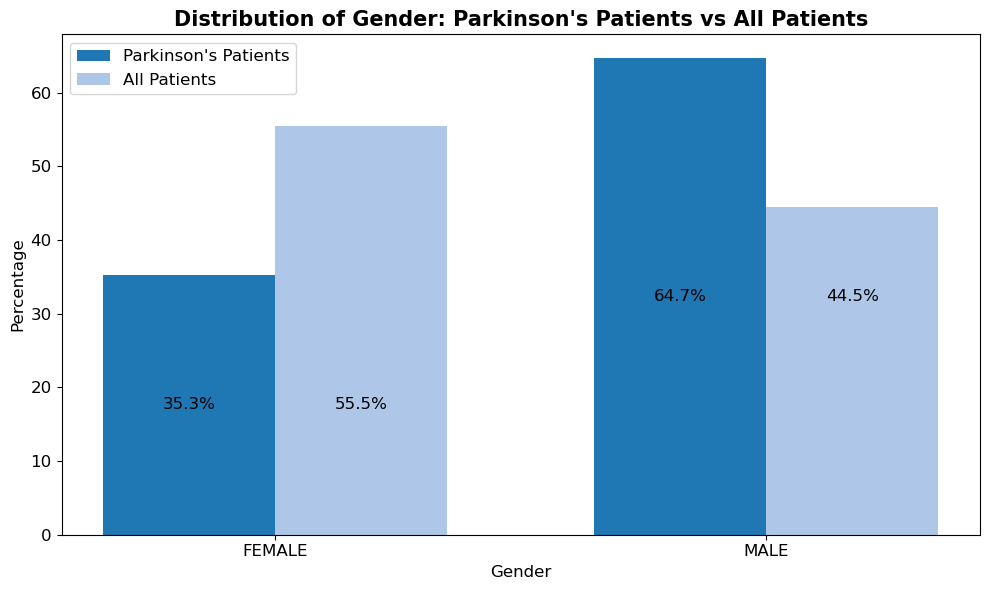

In [146]:
gender_counts = demographics['gender_source_value'].value_counts(normalize=True) * 100
gender_counts_all = demographics_all['gender_source_value'].value_counts(normalize=True)[:2] * 100 # Leaves out 'UNKNOWN' only 1 patient

# Combine percentages into a single DataFrame
combined_percentages = pd.DataFrame({
    "Parkinson's Patients": gender_counts,
    "All Patients": gender_counts_all
}).fillna(0)  # Fill NaN values with 0 in case some genders are missing in either group

# Plotting the percentage distribution of gender for both groups side by side
fig, ax = plt.subplots(figsize=(10, 6))

# Color map for the bar chart
colors = plt.cm.tab20.colors

# Calculate the width for each bar group
bar_width = 0.35

# Create the x positions for the bars
x = range(len(combined_percentages.index))

# Plot bars for Parkinson's patients
parkinsons_bars = ax.bar(x, combined_percentages["Parkinson's Patients"], width=bar_width, label="Parkinson's Patients", color=colors[0])

# Plot bars for all patients (shifted by bar_width)
all_patients_bars = ax.bar([i + bar_width for i in x], combined_percentages["All Patients"], width=bar_width, label="All Patients", color=colors[1])

# Set plot title and labels
ax.set_title("Distribution of Gender: Parkinson's Patients vs All Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Gender', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.legend(fontsize=12)

# Set the x-axis ticks to be at the center of the bars
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(combined_percentages.index, fontsize=12)

# Add the percentage values inside each bar
for bar1, bar2 in zip(parkinsons_bars, all_patients_bars):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width() / 2, height1 / 2, f"{height1:.1f}%", ha='center', va='center', fontsize=12)
    ax.text(bar2.get_x() + bar2.get_width() / 2, height1 / 2, f"{height2:.1f}%", ha='center', va='center', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [143]:
gender_counts_all[:2]

FEMALE    55.495608
MALE      44.504009
Name: gender_source_value, dtype: float64

In [ ]:
demographics['race_source_value'].value_counts()

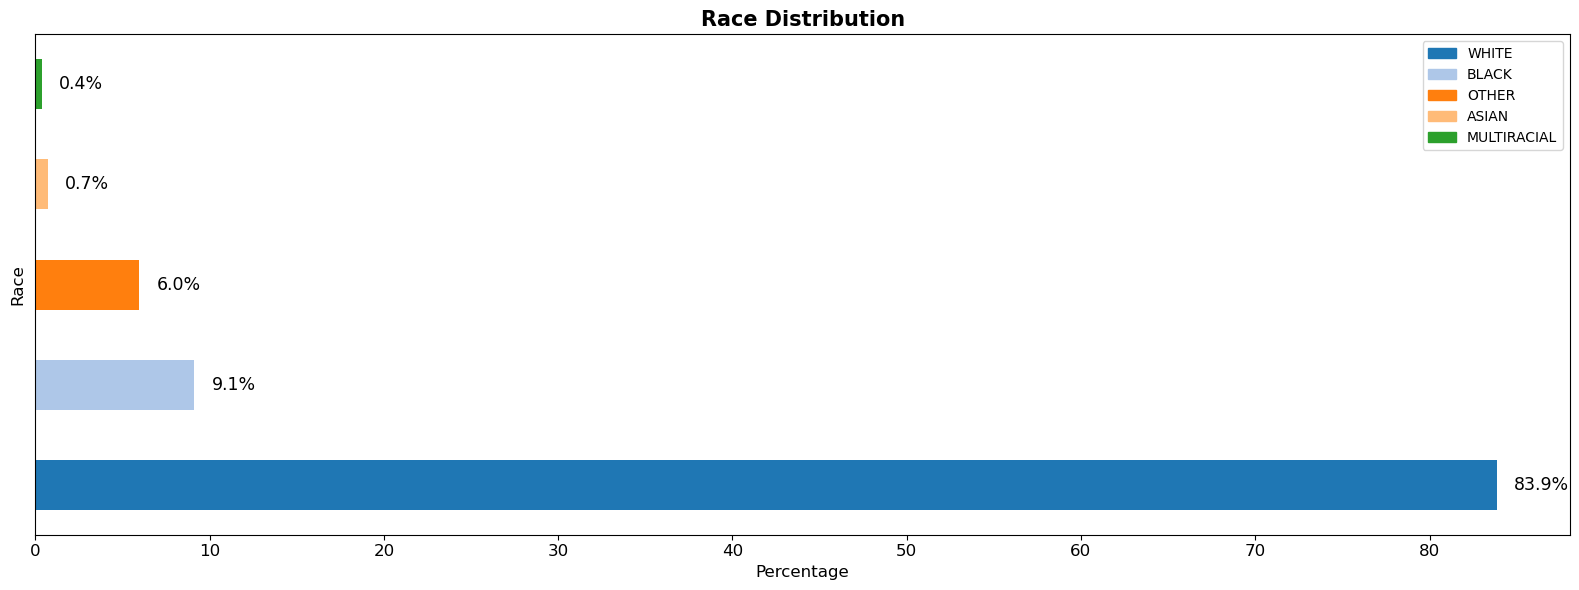

In [83]:
# Sample data (replace this with your actual data from the DataFrame)
race_counts = demographics['race_source_value'].value_counts(normalize=True) * 100

# Create a DataFrame from the data
race_df = pd.DataFrame({'Percentage': race_counts})

# Sort the DataFrame by percentage in descending order
race_df = race_df.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = race_df['Percentage'].plot(kind='barh', figsize=(16, 6), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title('Race Distribution', fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Race', fontsize=12)

# Add labels to the right of each bar
for i, v in enumerate(race_df['Percentage']):
    plt.text(v + 1, i, f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels
plt.yticks([])
plt.xticks(fontsize=12)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, race_counts.index)]

# Show the custom legend
plt.legend(handles=legend_patches, loc='best')

plt.tight_layout()
plt.show()

In [84]:
demographics['ethnicity_source_value'].value_counts()

NOT HISPANIC    272
HISPANIC         14
Name: ethnicity_source_value, dtype: int64

In [207]:
race_counts

WHITE          83.859649
BLACK           9.122807
OTHER           5.964912
ASIAN           0.701754
MULTIRACIAL     0.350877
Name: race_source_value, dtype: float64

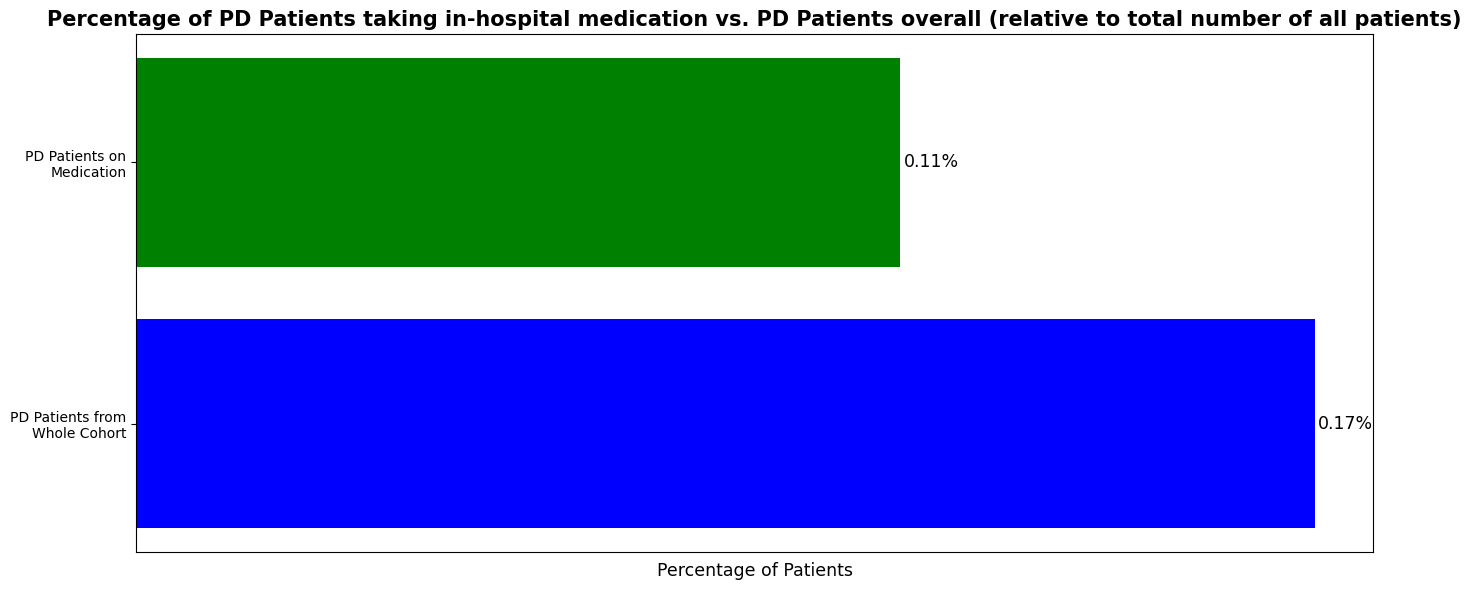

In [269]:
import matplotlib.pyplot as plt

# Calculate the total number of patients in each dataset
total_patients_df = len(df['person_id'].unique())
total_patients_df_pd = len(df_pd['person_id'].unique())
total_patients_demographics_all = len(demographics_all['person_id'].unique())

# Calculate the percentage of PD patients from the whole cohort and PD patients on medication
percentage_pd_patients_df = (total_patients_df / total_patients_demographics_all) * 100
percentage_pd_patients = (total_patients_df_pd / total_patients_demographics_all) * 100

# Create the data for the horizontal bar plot
categories = ['PD Patients from\nWhole Cohort', 'PD Patients on\nMedication']
values = [percentage_pd_patients_df, percentage_pd_patients]

# Set the figure size for the horizontal bar plot
plt.figure(figsize=(14, 6))

# Plot the horizontal bar plot
plt.barh(categories, values, color=['blue', 'green'])
plt.xlabel('Percentage of Patients', fontsize=12.5)
plt.title('Percentage of PD Patients taking in-hospital medication vs. PD Patients overall (relative to total number of all patients)', fontsize=15, fontweight='bold')
plt.ylabel('')
plt.xticks([])

# Display the percentage values inside the bars
for i, v in enumerate(values):
    plt.text(v + 0.0005, i, f"{v:.2f}%", ha='left', va='center', fontsize=12.5)

# Display the plot
plt.tight_layout()
plt.show()

In [263]:
percentage_pd_patients_df

0.1688658799022799

Percentage of patients diganosed with PD

In [208]:
all_patients

256936    23.728668
220757    10.102351
256706     3.937153
249161     3.814340
248934     3.081632
            ...    
202799     0.001075
203402     0.000989
180695     0.000989
200798     0.000817
257236     0.000731
Name: person_id, Length: 441, dtype: float64

In [ ]:
# Sample data (replace this with your actual data from the DataFrame)
ethnicity = demographics['ethnicity_source_value'].value_counts(normalize=True) * 100

# Create a DataFrame from the data
race_df = pd.DataFrame({'Percentage': race_counts})

# Sort the DataFrame by percentage in descending order
race_df = race_df.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = race_df['Percentage'].plot(kind='barh', figsize=(16, 6), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title('Race Distribution', fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Race', fontsize=12)

# Add labels to the right of each bar
for i, v in enumerate(race_df['Percentage']):
    plt.text(v + 1, i, f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels
plt.yticks([])
plt.xticks(fontsize=12)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, race_counts.index)]

# Show the custom legend
plt.legend(handles=legend_patches, loc='best')

plt.tight_layout()
plt.show()


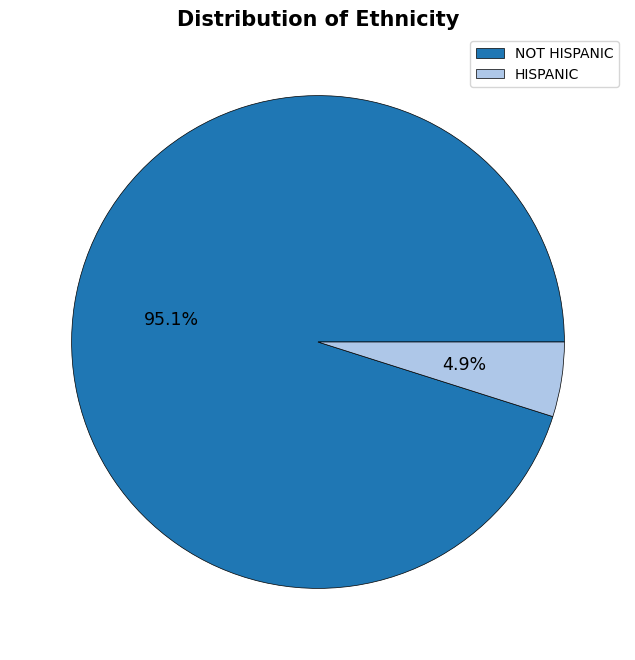

In [85]:
# Plotting value counts of race with percentages
ethnicity = demographics['ethnicity_source_value'].value_counts()
plt.figure(figsize=(18, 8))  # Adjust the values as per your desired size
labels = ethnicity.index
colors = plt.cm.tab20(np.arange(len(labels))) 
ax = ethnicity.plot.pie(labels=None, autopct='%.1f%%', colors=colors, wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'}, fontsize=12.5)

plt.title('Distribution of Ethnicity', fontsize=15, fontweight='bold')
plt.ylabel('')
plt.legend(labels, loc='best')
plt.show()

In [86]:
df_pd['age'].describe()

count    16040.000000
mean        70.831671
std         13.039556
min         31.000000
25%         64.000000
50%         72.000000
75%         80.000000
max        102.000000
Name: age, dtype: float64

Actual actual way to deal with this lol

In [87]:
demographics_all.columns

Index(['person_id', 'gender_source_value', 'race_source_value',
       'ethnicity_source_value', 'age'],
      dtype='object')

In [88]:
demographics

,person_id,age,gender_source_value,race_source_value,ethnicity_source_value
0,261006,74,MALE,WHITE,NOT HISPANIC
1,260996,76,FEMALE,WHITE,NOT HISPANIC
2,260956,88,FEMALE,WHITE,NOT HISPANIC
3,260918,79,FEMALE,WHITE,NOT HISPANIC
4,260872,74,MALE,BLACK,NOT HISPANIC
...,...,...,...,...,...
281,176706,78,FEMALE,WHITE,NOT HISPANIC
282,176462,68,MALE,WHITE,NOT HISPANIC
283,176417,77,MALE,WHITE,NOT HISPANIC
284,175744,90,MALE,WHITE,NOT HISPANIC


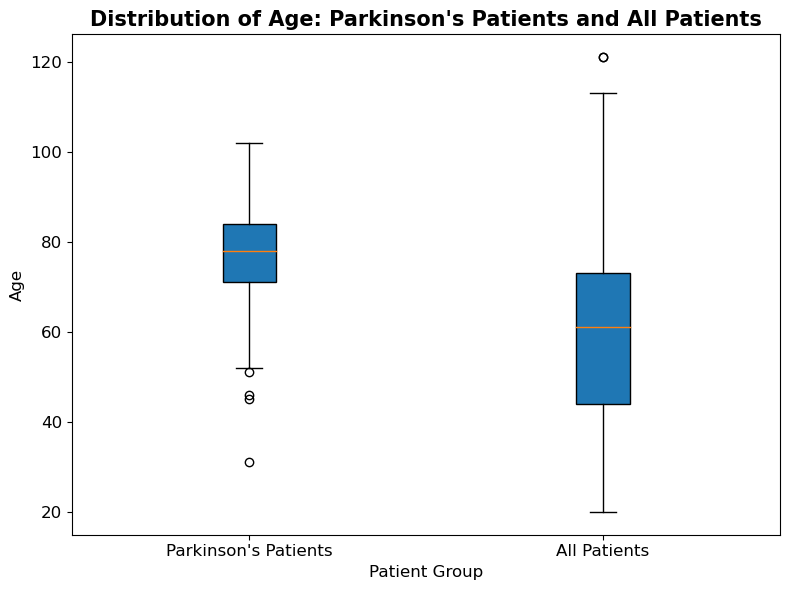

In [185]:
# Plotting the distribution of age for both groups using a box plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the box plot
ax.boxplot([demographics['age'], demographics_all['age']], labels=["Parkinson's Patients", "All Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Parkinson's Patients and All Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

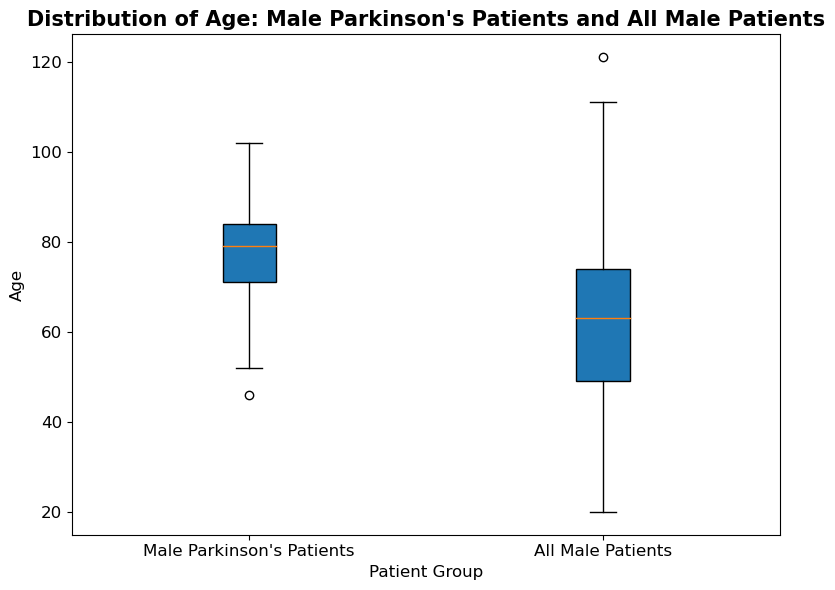

In [190]:
male_pd_patients_by_age = demographics[demographics['gender_source_value'] == 'MALE']['age']
male_pd_patients_by_age_all = demographics_all[demographics_all['gender_source_value'] == 'MALE']['age']# Plotting the distribution of age for both groups using a box plot

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age, male_pd_patients_by_age_all], labels=["Male Parkinson's Patients", "All Male Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male Parkinson's Patients and All Male Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [195]:
demographics[demographics['gender_source_value'] == 'MALE']['age'].describe()

count    185.000000
mean      77.713514
std       10.205448
min       46.000000
25%       71.000000
50%       79.000000
75%       84.000000
max      102.000000
Name: age, dtype: float64

In [194]:
demographics_all[demographics_all['gender_source_value'] == 'MALE']['age'].describe()

count    116224.000000
mean         61.051745
std          17.519295
min          20.000000
25%          49.000000
50%          63.000000
75%          74.000000
max         121.000000
Name: age, dtype: float64

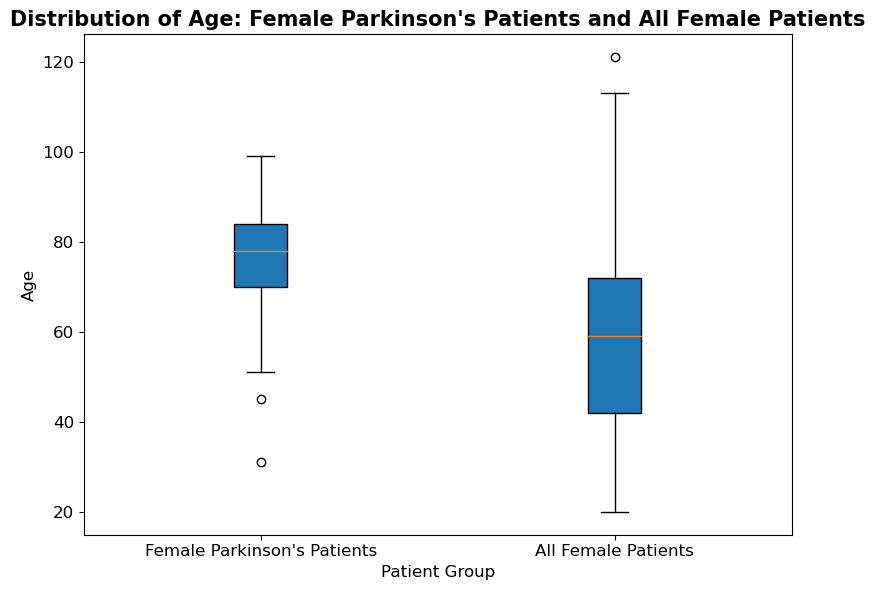

In [191]:
female_pd_patients_by_age = demographics[demographics['gender_source_value'] == 'FEMALE']['age']
female_pd_patients_by_age_all = demographics_all[demographics_all['gender_source_value'] == 'FEMALE']['age']

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([female_pd_patients_by_age, female_pd_patients_by_age_all], labels=["Female Parkinson's Patients", "All Female Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Female Parkinson's Patients and All Female Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [196]:
demographics[demographics['gender_source_value'] == 'FEMALE']['age'].describe()

count    101.000000
mean      76.435644
std       11.249370
min       31.000000
25%       70.000000
50%       78.000000
75%       84.000000
max       99.000000
Name: age, dtype: float64

In [197]:
demographics_all[demographics_all['gender_source_value'] == 'FEMALE']['age'].describe()

count    144929.000000
mean         57.522566
std          18.216179
min          20.000000
25%          42.000000
50%          59.000000
75%          72.000000
max         121.000000
Name: age, dtype: float64

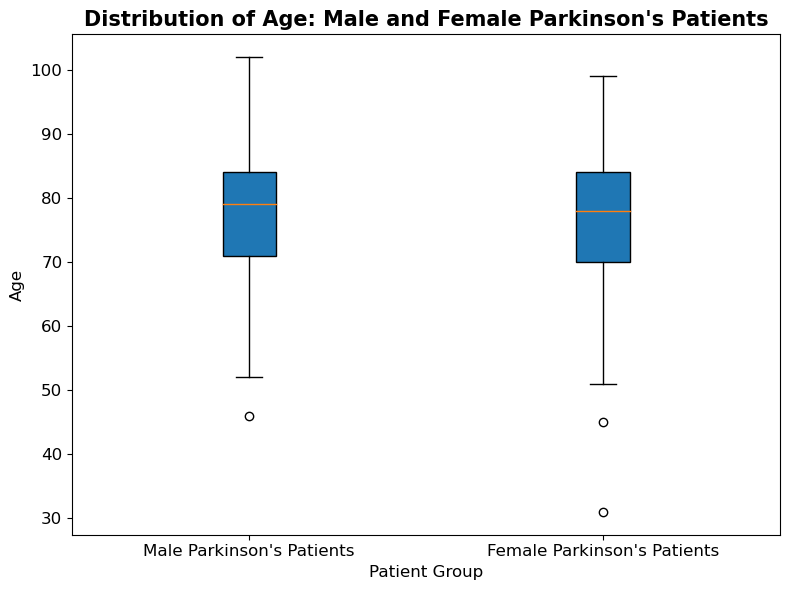

In [192]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age, female_pd_patients_by_age], labels=["Male Parkinson's Patients", "Female Parkinson's Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male and Female Parkinson's Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [198]:
demographics[demographics['gender_source_value'] == 'MALE']['age'].describe()

count    185.000000
mean      77.713514
std       10.205448
min       46.000000
25%       71.000000
50%       79.000000
75%       84.000000
max      102.000000
Name: age, dtype: float64

In [199]:
demographics[demographics['gender_source_value'] == 'FEMALE']['age'].describe()

count    101.000000
mean      76.435644
std       11.249370
min       31.000000
25%       70.000000
50%       78.000000
75%       84.000000
max       99.000000
Name: age, dtype: float64

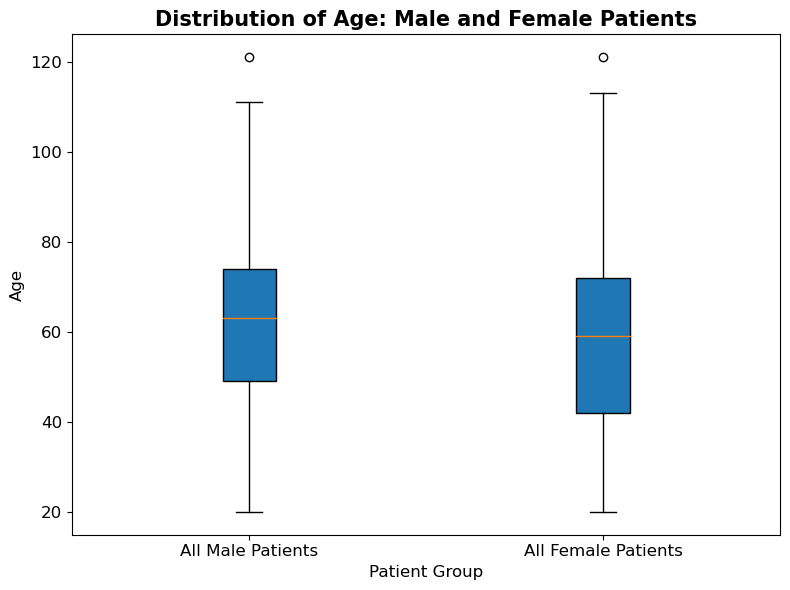

In [193]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age_all, female_pd_patients_by_age_all], labels=["All Male Patients", "All Female Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male and Female Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [200]:
demographics_all[demographics_all['gender_source_value'] == 'MALE']['age'].describe()

count    116224.000000
mean         61.051745
std          17.519295
min          20.000000
25%          49.000000
50%          63.000000
75%          74.000000
max         121.000000
Name: age, dtype: float64

In [201]:
demographics_all[demographics_all['gender_source_value'] == 'FEMALE']['age'].describe()

count    144929.000000
mean         57.522566
std          18.216179
min          20.000000
25%          42.000000
50%          59.000000
75%          72.000000
max         121.000000
Name: age, dtype: float64

In [96]:
pd_data.value_counts(normalize=True)

generic_name                           brand_name  dosage         
carbidopa-levodopa                     sinemet     25-100 mg          0.462317
                                       sinemet cr  25-100 mg          0.065251
benztropine                            cogentin    1 mg               0.064814
amantadine                             symmetrel   100 mg             0.059944
carbidopa-levodopa                     sinemet     25-250 mg          0.050078
pramipexole                            mirapex     0.25 mg            0.044771
benztropine                            cogentin    0.5 mg             0.035342
carbidopa-levodopa                     sinemet     10-100 mg          0.034093
                                                   12.5-50 mg         0.031033
                                       sinemet cr  50-200 mg          0.030097
benztropine                            cogentin    2 mg               0.014674
entacapone                             comtan      200 mg       

In [97]:
pd_data['brand_name'].value_counts(normalize=True)

sinemet       0.584523
cogentin      0.120347
sinemet cr    0.095217
symmetrel     0.074765
mirapex       0.069340
comtan        0.014965
artane        0.009728
azilect       0.007109
eldepryl      0.004303
duopa         0.003492
stalevo       0.003118
parlodel      0.003055
neupro        0.002681
gocovri       0.001995
parcopa       0.001372
rytary        0.001372
requip        0.000873
lodosyn       0.000686
tasmar        0.000624
dostinex      0.000249
apokyn        0.000187
Name: brand_name, dtype: float64

In [98]:
pd_data

,generic_name,brand_name,dosage
0,carbidopa-levodopa,sinemet,25-100 mg
1,carbidopa-levodopa,sinemet,25-100 mg
2,amantadine,symmetrel,100 mg
3,amantadine,symmetrel,100 mg
4,amantadine,symmetrel,100 mg
...,...,...,...
16035,carbidopa-levodopa,sinemet,25-100 mg
16036,carbidopa-levodopa,sinemet,25-100 mg
16037,carbidopa-levodopa,sinemet,25-100 mg
16038,carbidopa-levodopa,sinemet,25-100 mg


In [99]:
len(demographics)

286

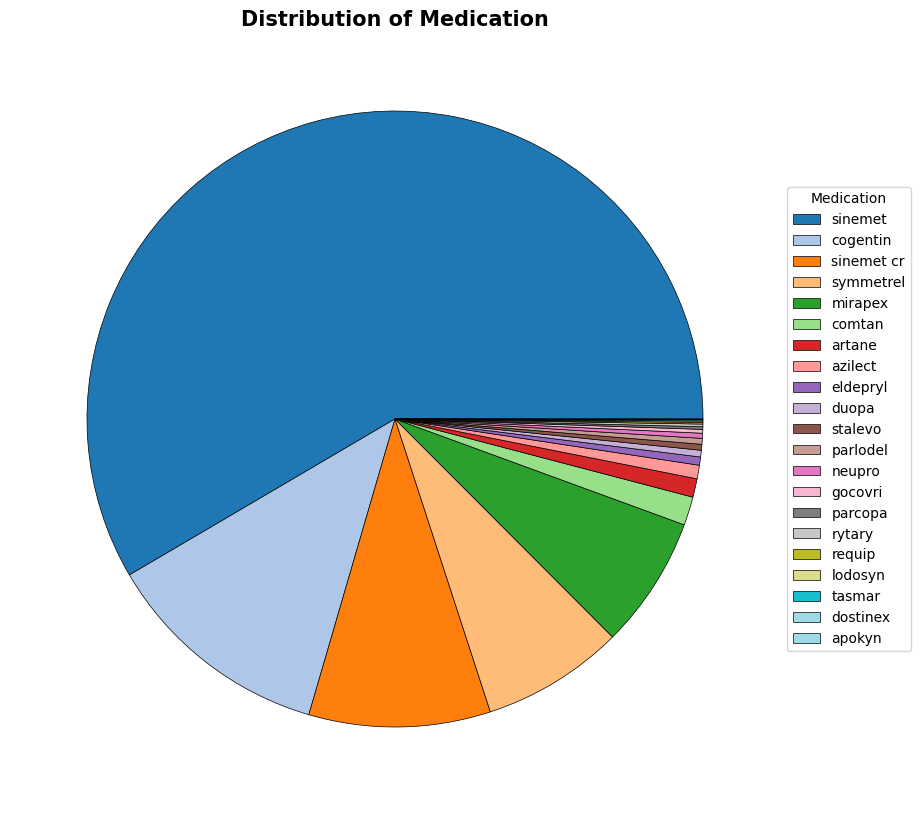

In [100]:
# Plotting value counts of race with percentages
medication_data = pd_data['brand_name'].value_counts()
plt.figure(figsize=(10, 10))  # Adjust the values as per your desired size
# ax = race_counts.plot.pie(autopct='%.1f%%', colormap='bwr')
# ax = race_counts.plot.pie(autopct='%.1f%%', colormap='Spectral')
# Plotting the pie chart without labels inside the pie slices
# Get the number of medications
num_medications = len(medication_data)

# Generate a colormap based on the number of medications
colormap = plt.cm.get_cmap('tab20', num_medications)

# Plotting the pie chart without labels inside the pie slices
_, _, autotexts = plt.pie(medication_data, labels=None, autopct='', pctdistance=1.2, colors=colormap(range(num_medications)), wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'}, textprops={'fontsize': 12})

plt.title('Distribution of Medication', fontsize=15, fontweight='bold')
plt.legend(medication_data.index, title='Medication', loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(autotexts, size=8, weight='bold')
plt.axis('off')
plt.show()

In [101]:
len(pd_data) == len(df_pd)

True

In [102]:
df_pd.iloc[5187]

person_id                                                            250766
age                                                                      85
gender_source_value                                                  FEMALE
race_source_value                                                     WHITE
ethnicity_source_value                                         NOT HISPANIC
drug_source_value         {"med_display_name": "**carbidopa-levodopa 4.6...
drug_info                 **carbidopa-levodopa 4.63-20 mg/mL (DUOPA) sus...
generic_name                                             carbidopa-levodopa
brand_name                                                            duopa
dosage                                                        4.63-20 mg/ml
quantity                                                              100.0
sig                                                                   DAILY
route_source_value                                               PER J TUBE
dose_source_

In [103]:
pd_data.iloc[5187]

generic_name    carbidopa-levodopa
brand_name                   duopa
dosage               4.63-20 mg/ml
Name: 5187, dtype: object

In [104]:
len(pd_data[pd_data['brand_name'] == 'duopa']) == len(df_pd[df_pd['brand_name'] == 'duopa'])

True

<AxesSubplot: >

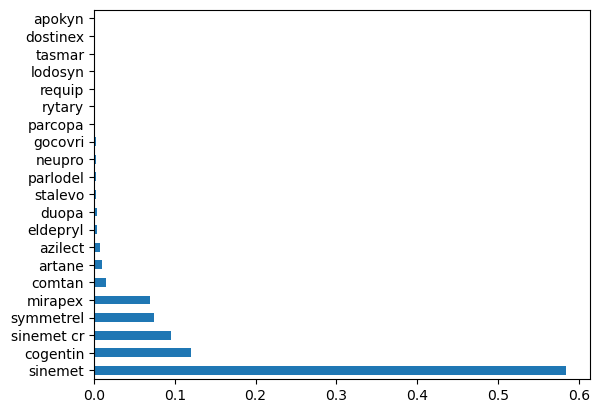

In [105]:
# vlalue_counts: Number of times each unique elements appears
medication_data = pd_data['brand_name'].value_counts(normalize=True)
medication_data.plot(kind='barh')

In [106]:
df_pd.groupby('brand_name')['person_id'].nunique()

brand_name
apokyn          1
artane          7
azilect        12
cogentin       22
comtan          8
dostinex        1
duopa           2
eldepryl        5
gocovri         1
lodosyn         4
mirapex        29
neupro          8
parcopa         2
parlodel        2
requip          3
rytary          2
sinemet       244
sinemet cr     82
stalevo         4
symmetrel      33
tasmar          1
Name: person_id, dtype: int64

In [107]:
df_pd['brand_name'].nunique()

21

In [155]:
df_pd.columns

Index(['person_id', 'age', 'gender_source_value', 'race_source_value',
       'ethnicity_source_value', 'drug_source_value', 'drug_info',
       'generic_name', 'brand_name', 'dosage', 'quantity', 'sig',
       'route_source_value', 'dose_source_value', 'dose_unit_source_value',
       'note_text'],
      dtype='object')

In [166]:
df_pd['race_source_value'].value_counts(normalize=True)

WHITE          0.624041
BLACK          0.332689
OTHER          0.031673
MULTIRACIAL    0.008729
ASIAN          0.002868
Name: race_source_value, dtype: float64

In [165]:
demographics['race_source_value'].value_counts(normalize=True)

WHITE          0.838596
BLACK          0.091228
OTHER          0.059649
ASIAN          0.007018
MULTIRACIAL    0.003509
Name: race_source_value, dtype: float64

In [163]:
# Drug usage per patient
drug_percentage = df_pd.groupby('race_source_value')['person_id'].nunique()/ df_pd['person_id'].nunique()
drug_percentage.sort_values(ascending=False)
# drug_percentage

race_source_value
WHITE          0.835664
BLACK          0.090909
OTHER          0.059441
ASIAN          0.006993
MULTIRACIAL    0.003497
Name: person_id, dtype: float64

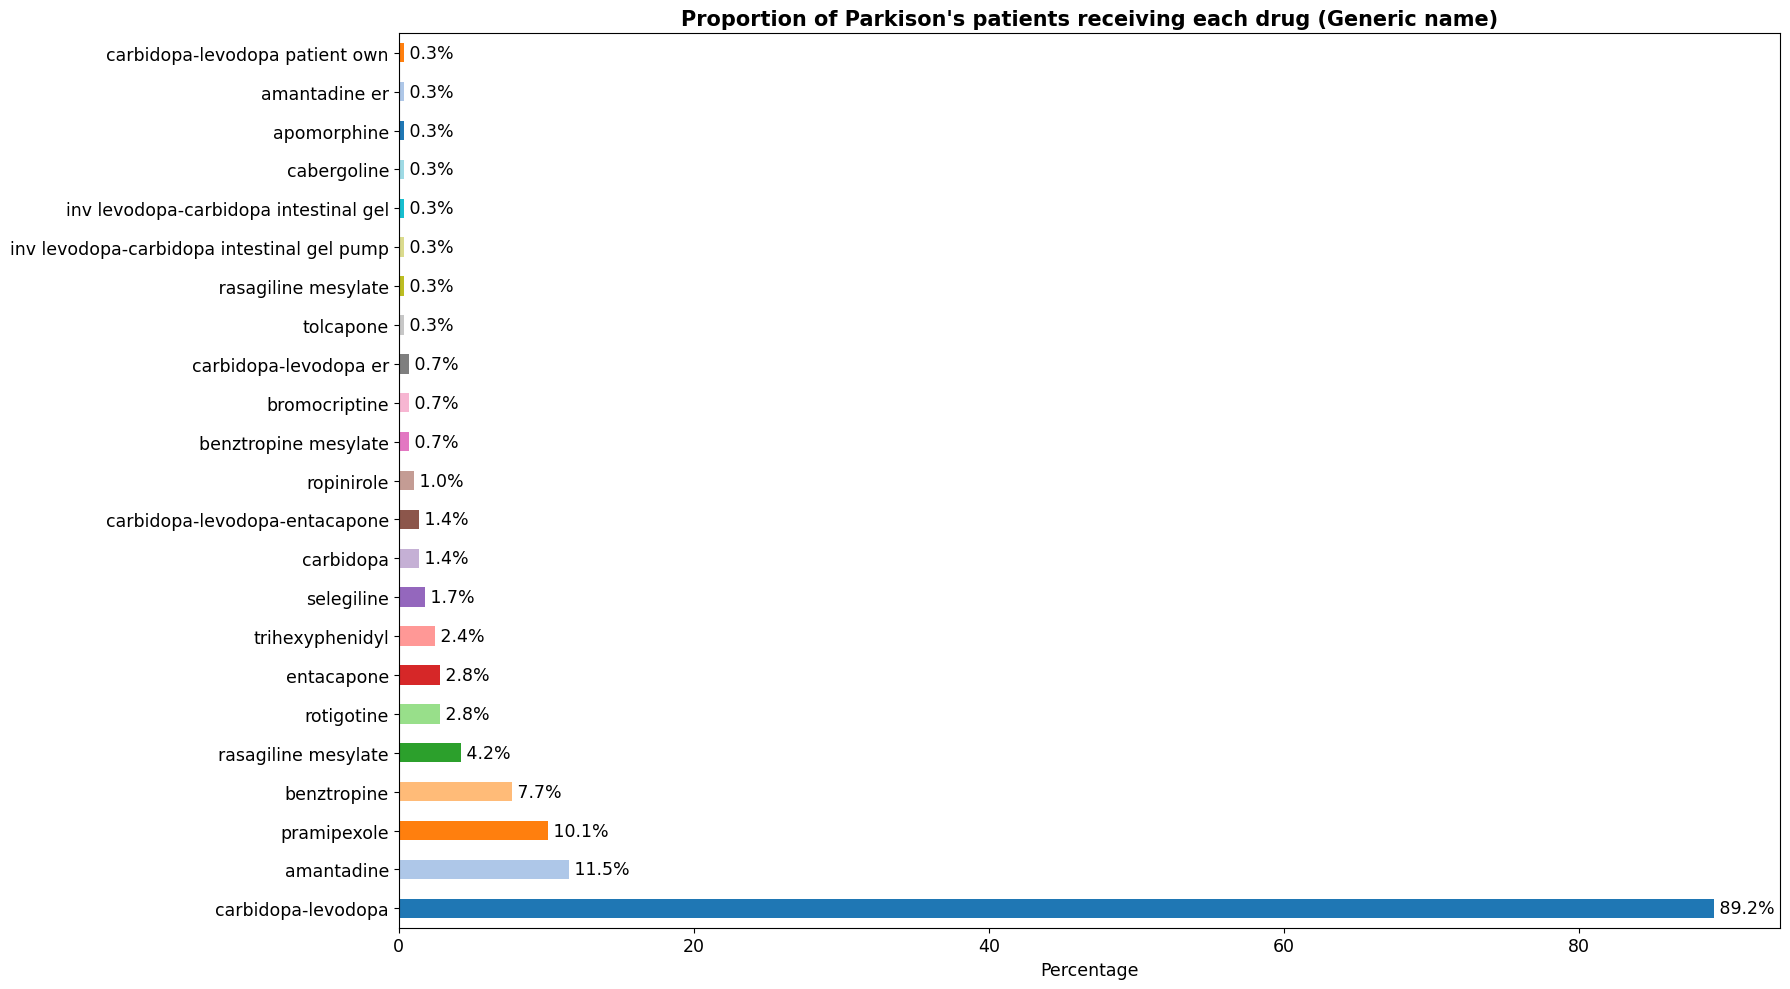

In [248]:
drug_percentage = df_pd.groupby('generic_name')['person_id'].nunique()/ df_pd['person_id'].nunique()
drug_popularity_count = drug_percentage * 100
drug_popularity = pd.DataFrame({'Percentage': drug_popularity_count})

# Sort the DataFrame by percentage in descending order
drug_popularity = drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Parkison's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(drug_popularity)), drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()


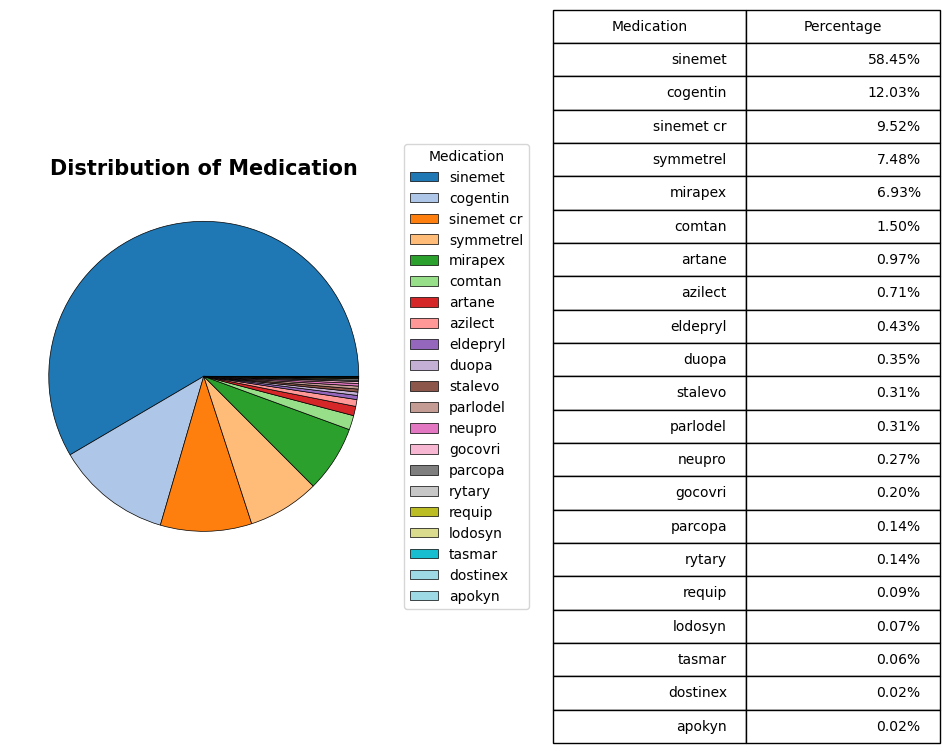

In [110]:
medication_data = pd_data['brand_name'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the pie chart without labels inside the pie slices
wedges, _, autotexts = ax1.pie(medication_data, labels=None, autopct='', colors=plt.cm.tab20(range(len(medication_data))), wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'}, textprops={'fontsize': 12})

ax1.set_title('Distribution of Medication', fontweight='bold', fontsize=15)
ax1.legend(wedges, medication_data.index, title='Medication', loc='center left', bbox_to_anchor=(1, 0.5))

# Create a table to display the percentages
table_data = [(medication, f'{count / sum(medication_data) * 100:.2f}%') for medication, count in medication_data.items()]
table = ax2.table(cellText=table_data, colLabels=['Medication', 'Percentage'], loc='center')

# Adjust the table appearance
table.scale(1, 2)
table.auto_set_font_size(False)
table.set_fontsize(10)

ax2.axis('off')

plt.subplots_adjust(wspace=0.4)  # Adjust the spacing between subplots
plt.show()


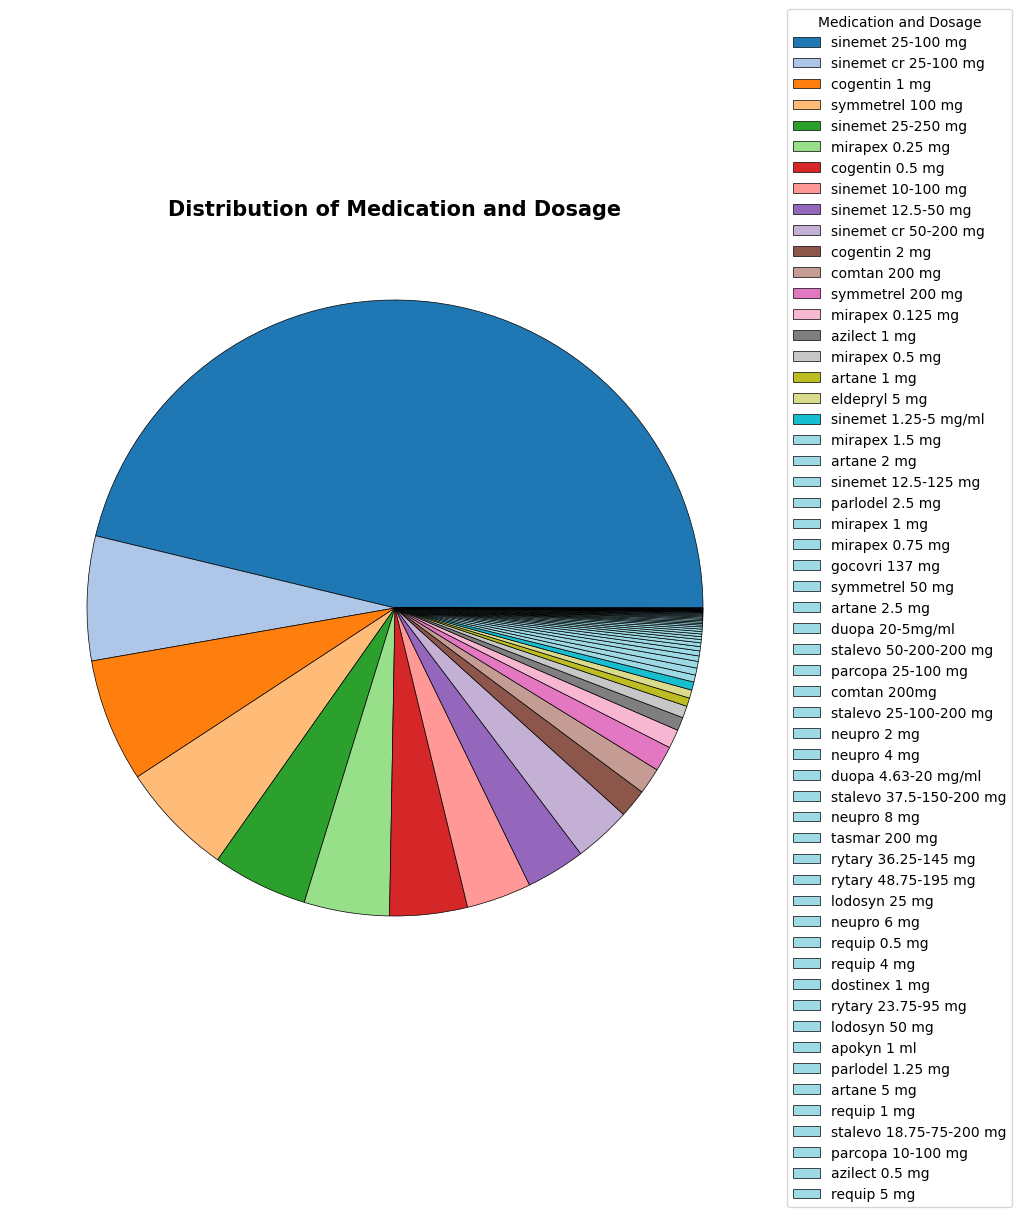

In [111]:

# Combine 'brand_name' and 'dosage' columns
combined_data = pd_data['brand_name'] + ' ' + pd_data['dosage']

# Calculate value counts
medication_data = combined_data.value_counts()

plt.figure(figsize=(10, 10))

# Plotting the pie chart without labels inside the pie slices
_, _, autotexts = plt.pie(medication_data, labels=None, autopct='', colors=plt.cm.tab20(range(len(medication_data))), wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'}, textprops={'fontsize': 12})

plt.title('Distribution of Medication and Dosage', fontweight='bold', fontsize=15)
plt.legend(medication_data.index, title='Medication and Dosage', loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(autotexts, size=8, weight='bold')
plt.axis('off')
plt.show()


/tmp/ipykernel_69512/3041872048.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


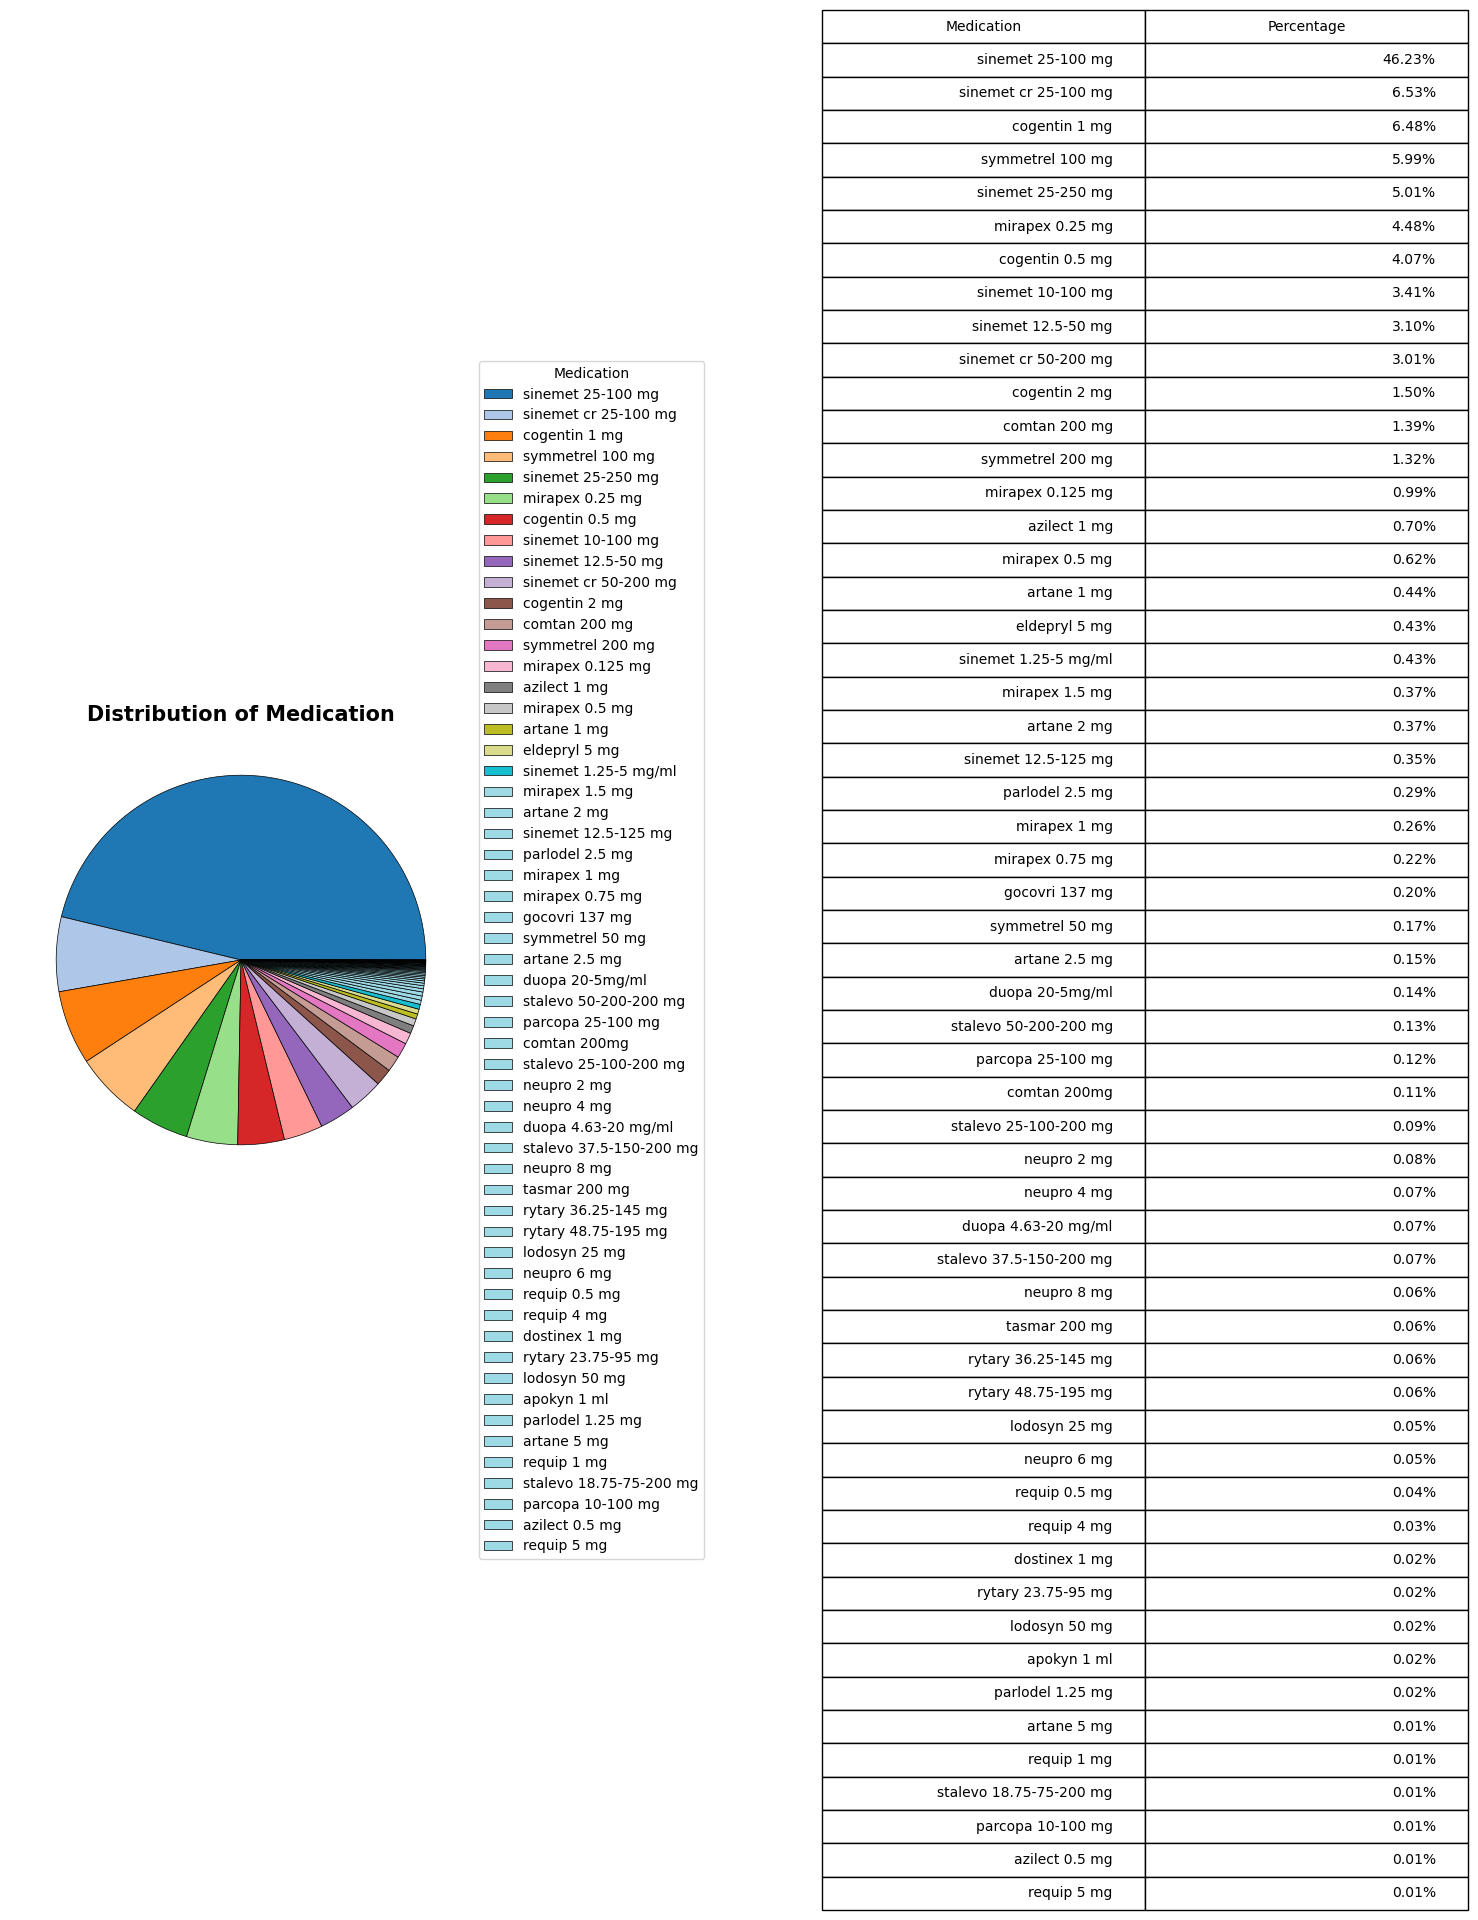

In [112]:
combined_data = pd_data['brand_name'] + ' ' + pd_data['dosage']
medication_data = combined_data.value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plotting the pie chart without labels inside the pie slices
wedges, _, autotexts = ax1.pie(medication_data, labels=None, autopct='', colors=plt.cm.tab20(range(len(medication_data))), wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'}, textprops={'fontsize': 12})

ax1.set_title('Distribution of Medication', fontweight='bold', fontsize=15)
ax1.legend(wedges, medication_data.index, title='Medication', loc='center left', bbox_to_anchor=(1, 0.5))

# Create a table to display the percentages
table_data = [(medication, f'{count / sum(medication_data) * 100:.2f}%') for medication, count in medication_data.items()]
table = ax2.table(cellText=table_data, colLabels=['Medication', 'Percentage'], loc='center')

# Adjust the table appearance
table.scale(1, 2)
table.auto_set_font_size(False)
table.set_fontsize(10)

ax2.axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)  # Adjust the spacing between subplots
plt.show()

Medication by gender (I can do this beause both dataframes are the same lenght)

In [113]:
medication_male = pd_data[df_pd['gender_source_value'] == 'MALE']
medication_female = pd_data[df_pd['gender_source_value'] == 'FEMALE']

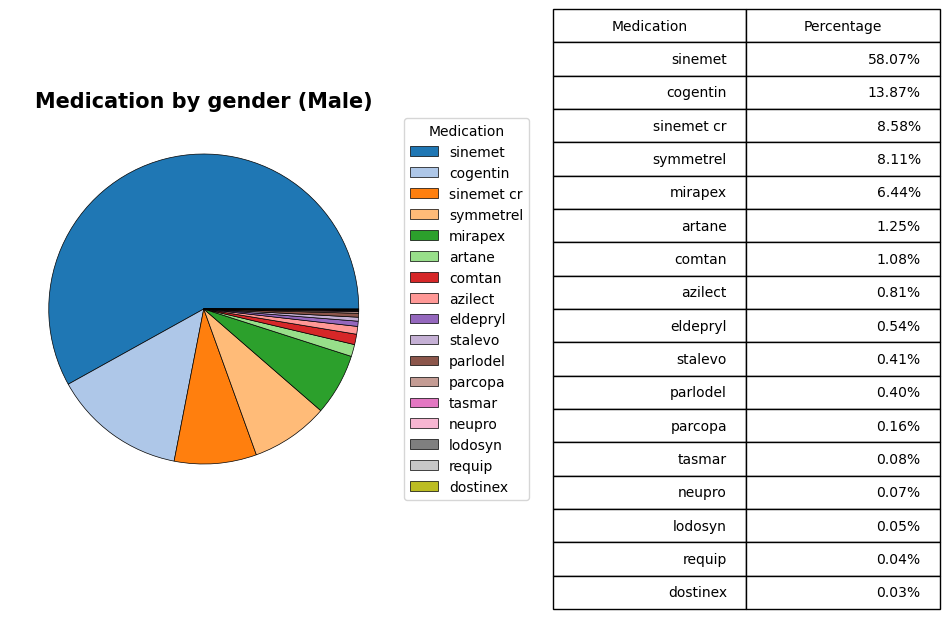

In [114]:
medication_data_male = medication_male['brand_name'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the pie chart without labels inside the pie slices
wedges, _, autotexts = ax1.pie(medication_data_male, labels=None, autopct='', colors=plt.cm.tab20(range(len(medication_data_male))), wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'}, textprops={'fontsize': 12})

ax1.set_title('Medication by gender (Male)', fontweight='bold', fontsize=15)
ax1.legend(wedges, medication_data_male.index, title='Medication', loc='center left', bbox_to_anchor=(1, 0.5))

# Create a table to display the percentages
table_data = [(medication, f'{count / sum(medication_data_male) * 100:.2f}%') for medication, count in medication_data_male.items()]
table = ax2.table(cellText=table_data, colLabels=['Medication', 'Percentage'], loc='center')

# Adjust the table appearance
table.scale(1, 2)
table.auto_set_font_size(False)
table.set_fontsize(10)

ax2.axis('off')

plt.subplots_adjust(wspace=0.4)  # Adjust the spacing between subplots
plt.show()


In [115]:
## Number of patients who received X
df_pd['brand_name']

0          sinemet
1          sinemet
2        symmetrel
3        symmetrel
4        symmetrel
           ...    
16035      sinemet
16036      sinemet
16037      sinemet
16038      sinemet
16039      sinemet
Name: brand_name, Length: 16040, dtype: object

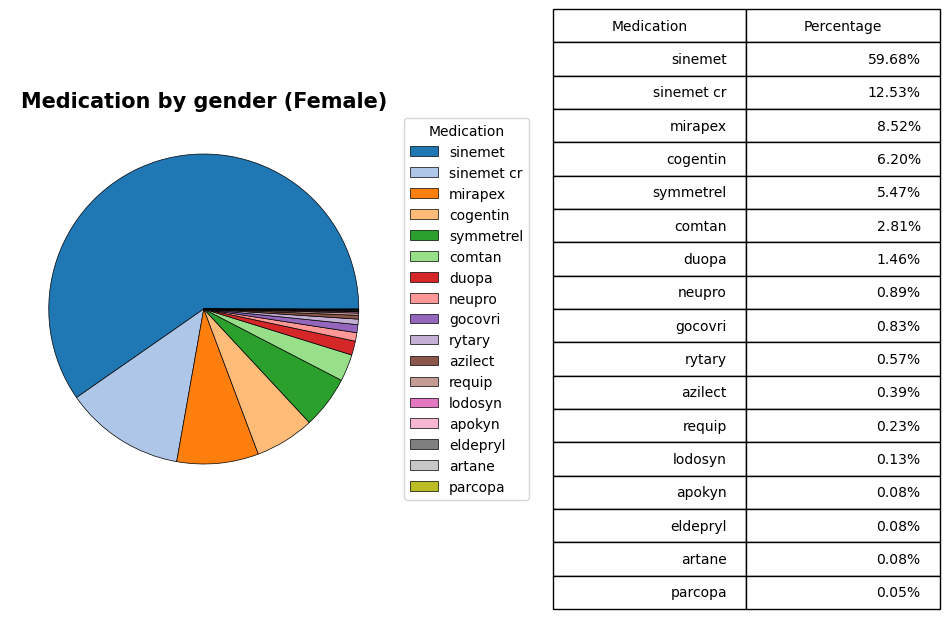

In [116]:
medication_data_female = medication_female['brand_name'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the pie chart without labels inside the pie slices
wedges, _, autotexts = ax1.pie(medication_data_female, labels=None, autopct='', colors=plt.cm.tab20(range(len(medication_data_female))), wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'}, textprops={'fontsize': 12})

ax1.set_title('Medication by gender (Female)', fontweight='bold', fontsize=15)
ax1.legend(wedges, medication_data_female.index, title='Medication', loc='center left', bbox_to_anchor=(1, 0.5))

# Create a table to display the percentages
table_data = [(medication, f'{count / sum(medication_data_female) * 100:.2f}%') for medication, count in medication_data_female.items()]
table = ax2.table(cellText=table_data, colLabels=['Medication', 'Percentage'], loc='center')

# Adjust the table appearance
table.scale(1, 2)
table.auto_set_font_size(False)
table.set_fontsize(10)

ax2.axis('off')

plt.subplots_adjust(wspace=0.4)  # Adjust the spacing between subplots
plt.show()

In [117]:
print(len(df['person_id'].unique()))
print(len(df_pd['person_id'].unique()))

441
286
